In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from xml.etree import ElementTree as ET
from io import StringIO

import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px

# 05-Compare holdings
***R Persichitte<br>7/21/2020***

## Purpose
This notebook uses the functions aggregated from notebook 4 to create useful outputs. 

It has two outputs:
- Accept a list of securities and show the asset classes and asset issuers as identified in the form NPORT.
- Accept a list of securities by Series ID then return a list of how much they overlap.

<hr>

## Methods

Import functions from previous

In [2]:
# From 02-NPORT function.ipynb
class download_NPORT:
    def __init__(self, link):
        r = requests.get(link)
        assert(r), r
        xml = ET.fromstring(r.text)
        
        # Remove namespace tags
        xml = ET.iterparse(StringIO(r.text))
        for _, el in xml:
            _, _, el.tag = el.tag.rpartition('}') # strip ns
        self.xml = xml.root
    def parseSecurities(self):
        secs = self.xml.find('formData').find('invstOrSecs')
        all_secs = []
        for s in secs:
            t_dict = {}
            for e in s:
                t_dict[e.tag] = e.text 
            all_secs += [t_dict]
        res = pd.DataFrame(all_secs)
                
        # Extra data cleaning to convert strings to numbers
        num_cols = ['valUSD','balance','pctVal']
        
        for c in num_cols:
            res[c] = res[c].astype(float)
        
        return res
    def parseFundInfo(self):
        fund_info = {}
        for e in list(self.xml.find('formData').find('fundInfo')):
            fund_info[e.tag] = e.text
        
        return fund_info
    
# From 03-EDGAR getall
## NOTE: Although not expressly later int he document, the functions call other functions.
## All are necessary.
def get_EDGAR_index(year,quarter):
    assert(int(year)>1933), 'Year before SEC.'
    assert(int(year)<=datetime.now().year), 'Year in future'
    assert(0<int(quarter)<5), 'Invalid quarter.'
    
    
    url = 'https://www.sec.gov/Archives/edgar/full-index/{:}/QTR{:}/master.idx'
    url = url.format(int(year),int(quarter))
    return pd.read_csv(url,sep='|',
                       skip_blank_lines=True,
                       skiprows=[0,1,2,3,4,5,6,7,8,10],
                       parse_dates=['Date Filed'])
def get_filings(CIK,page:int=0,n_records:int=100,type_=''):
    assert(type(page)==int),'Page must be an int.'
    assert(type(n_records==int)), 'n_records must be an int.'
    
    ed_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    r = requests.get(ed_url,params = dict(
        action='getcompany',
        CIK=CIK,
        count=n_records,
        start=page*n_records,
        type=type_
    ))
    assert(r),r
    
    try:
        soup = BeautifulSoup(r.text,'lxml')
        
        # Look if request is valid
        if "Invalid parameter" in [h.text for h in soup.findAll('h1')]:
            return 'Invalid parameter'
    
        # Get table of filings and parse
        filings = list(soup.find(class_="tableFile2").find_all('tr'))
        header = filings.pop(0)# Drop first row which only contains file headers.
        res = []
        
        if len(filings)>0:
            for f in filings:
                f = list(f.findAll('td'))
                t_dict = dict()
                t_dict['Filings'] = f[0].text
                t_dict['Format'] = f[1].find('a').get('href')
                t_dict['Filing Date'] = f[3].text
                t_dict['File/Film Number'] = f[4]
                res += [t_dict]
                
            res = pd.DataFrame(res)
            res['Filing Date'] = pd.to_datetime(res['Filing Date'])
            return res
        else:
            return ('No results.')
    except:
        print('ERROR PARSING!')
        return r
def get_all_pages(CIK,n_records:int=100,type_=''):
    

    valid = True
    page = 0
    
    res = pd.DataFrame()
    while valid:
        tdf = get_filings(CIK=CIK,
                          page=page,
                          n_records=n_records,
                          type_=type_)
        
        if(type(tdf)!=pd.DataFrame):
            valid = False
            break
        else:
            page+=1
            res = pd.concat([res,tdf])
        
    return res.reset_index(drop=True)
def get_most_recent(CIK:str,n_records:int=100,type_:str='NPORT-P')->download_NPORT:
    '''CIK: this should be a CIK or Series number for the fund. For companies with multiple funds (E.g. Schwab)
            using the CIK will result in the NPORT for the fund that was filed most recently. Multiple ticker symbols
            can trade under the same CIK, but will have unique Seires numbers. Different classes of the same fund
            will chase a Series number if they are based on the same investment series.
       n_records: specifies the number of records to pull for each EDGAR query.
            The options as of 6/8 are 40,60,80,and 100. This is included for flexibility 
            in case EDGAR changes allowed options.
        type_: is the string to pass to EDGAR regarding type. It should always be NPORT-P, but I am
            making this a variable in case the name changes in the future.
            
        Based on the series ID, this will return a download_NPORT object. Using this object, you can download
        a list of securities in the form of a pandas datafram using the command `parseSecurities()`. You can 
        get a dictionary of general fund infor using `parseFundInfo()`. You can get the XMLetree by accesing
        `xml`.
        '''
    #pull the given url of the most recent.
    recent = (
        get_all_pages(CIK,n_records=n_records,type_=type_)
            .sort_values('Filing Date',ascending=False)
            .head(1)['Format'].values[0]
    )
    
    # The URL by default is the HTML file. We need to modify it to get the XML data.
    ## Strip HTML part of link
    recent = recent[:recent.rfind('/')]
    
    ## Add information to access XML
    link = "https://www.sec.gov{:}/primary_doc.xml".format(recent)
    
    return download_NPORT(link)

Import a list of securities (these are the holdings in my IRA)

In [3]:
secs = pd.read_excel('Persichitte 2020-06-08.xlsx',sheet_name='Summary')

secs.rename(columns={'Row Labels':'class_ticker','Sum of Mkt Value':'Amount'},inplace=True)
secs = secs.merge(
    pd.read_pickle('Investment Company Series and Class Information.p'),
    on='class_ticker',
    how='inner'
)
secs.sort_values('series_name')

class_ticker   Amount reporting_file_number         cik  \
5         MFAEX  1127.51             811-22449  0001496998   
0          BLOK   406.00             811-23108  0001633061   
17          URA   768.49             811-22209  0001432353   
1         HLEMX  2111.38             811-07739  0001018170   
18        USIBX  3547.60             811-07852  0000908695   
2         JERTX  2961.54             811-01879  0000277751   
6         PCLAX  2535.53             811-05028  0000810893   
3          MDYG   887.04             811-08839  0001064642   
4          MDYV   518.80             811-08839  0001064642   
13         SLYG   761.34             811-08839  0001064642   
14         SLYV   613.19             811-08839  0001064642   
8          SCHF  6253.05             811-22311  0001454889   
7          SCHC   138.41             811-22311  0001454889   
15        SWPPX  6583.01             811-07704  0000904333   
16        SWSSX  5631.28             811-07704  0000904333   
9          SCHG  9959.96             811-22311  0001454889   
12         SCHV  1937.74             811-22311  0001454889   
11         SCHM  8748.63             811-22311  0001454889   
10         SCHH  2217.71             811-22311  0001454889   

                     entity_name entity_org_type   series_id  \
5   AMERICAN FUNDS MORTGAGE FUND              30  S000030190   
0              Amplify ETF Trust              30  S000061158   
17                Global X Funds              30  S000029442   
1      HARDING LOEVNER FUNDS INC              30  S000004201   
18       USAA MUTUAL FUNDS TRUST              30  S000012902   
2          JANUS INVESTMENT FUND              30  S000025889   
6                    PIMCO FUNDS              30  S000028928   
3              SPDR SERIES TRUST              30  S000006987   
4              SPDR SERIES TRUST              30  S000006988   
13             SPDR SERIES TRUST              30  S000006990   
14             SPDR SERIES TRUST              30  S000006974   
8         SCHWAB STRATEGIC TRUST              30  S000026637   
7         SCHWAB STRATEGIC TRUST              30  S000026638   
15          SCHWAB CAPITAL TRUST              30  S000005911   
16          SCHWAB CAPITAL TRUST              30  S000005912   
9         SCHWAB STRATEGIC TRUST              30  S000026633   
12        SCHWAB STRATEGIC TRUST              30  S000026634   
11        SCHWAB STRATEGIC TRUST              30  S000026635   
10        SCHWAB STRATEGIC TRUST              30  S000030518   

                                   series_name    class_id  \
5                 AMERICAN FUNDS MORTGAGE FUND  C000092906   
0    Amplify Transformational Data Sharing ETF  C000198131   
17                        Global X Uranium ETF  C000090393   
1   Harding Loevner Emerging Markets Portfolio  C000011821   
18                 Intermediate-Term Bond Fund  C000034871   
2      Janus Henderson Global Real Estate Fund  C000077601   
6          PIMCO CommoditiesPLUS Strategy Fund  C000088650   
3         SPDR(R) S & P 400 Mid Cap Growth ETF  C000019040   
4          SPDR(R) S & P 400 Mid Cap Value ETF  C000019041   
13      SPDR(R) S & P 600 Small Cap Growth ETF  C000019043   
14       SPDR(R) S & P 600 Small Cap Value ETF  C000019027   
8              Schwab International Equity ETF  C000079984   
7    Schwab International Small-Cap Equity ETF  C000079985   
15                   Schwab S&P 500 Index Fund  C000016166   
16                 Schwab Small-Cap Index Fund  C000016169   
9             Schwab U.S. Large-Cap Growth ETF  C000079980   
12             Schwab U.S. Large-Cap Value ETF  C000079981   
11                     Schwab U.S. Mid-Cap ETF  C000079982   
10                        Schwab U.S. REIT ETF  C000094080   

                                   class_name                 address_1  \
5                                   Class F-1  6455 IRVINE CENTER DRIVE   
0   Amplify Transformational Data Sharing ETF           310 S. HALE ST.   
17             

Define class to handle all securities

In [4]:
class aggregate_SID_holdings:
    def __init__(
        self,
        df:pd.DataFrame,
        sid_column:str,
        amount_column:str,
        n_records:int=100,
        type_:str='NPORT-P'
    ):
        print('Importing holdings by Series IDs')
        tdf = df[[sid_column,amount_column]]
        all_NPORT = pd.DataFrame()
        
        for i in tdf.index:
            sid = tdf.iloc[i][sid_column]
            print('------------------\n',sid)
            
            try:
                # Create a running list of all security info
                NPORT = get_most_recent(sid).parseSecurities()
                print(NPORT.shape[0],'securities downloaded.')
                
                NPORT['Source'] = sid
                
                ## Create columns for cusips with NA
                # Replace 'N/A' values
                NPORT['cusip_clean'] = NPORT['cusip']
                mask = (NPORT['cusip_clean']=='N/A') | (NPORT['cusip_clean']=='000000000') | NPORT['cusip_clean'].isna()
                NPORT.loc[mask,'cusip_clean'] = NPORT.loc[mask,'lei']
                
                # Replace where N/A is in 'lei'
                mask = (NPORT['cusip_clean']=='N/A') | (NPORT['cusip_clean']=='000000000') | NPORT['cusip_clean'].isna()
                NPORT.loc[mask,'cusip_clean'] = NPORT.loc[mask,'title']
                
                
                ## Add column for merge with absolute values in portfolio
                try:
                    NPORT['PortfolioValue'] = NPORT['pctVal'] * tdf.iloc[i][amount_column] / 100
                except:
                    print('Error determing value of individual holdings.')
                    NPORT['PortfolioValue'] = np.nan
                
                
                all_NPORT = pd.concat([all_NPORT,NPORT],sort=False)
            except:
                print('Unable to download securities.')
                
                
        # Store results in the class object
        self.all_NPORT = all_NPORT
        
        print('------------------\nComplete\n------------------')
        return

holds = aggregate_SID_holdings(secs,amount_column='Amount',sid_column='series_id')

Importing holdings by Series IDs
------------------
 S000061158
57 securities downloaded.
------------------
 S000004201
77 securities downloaded.
------------------
 S000025889
61 securities downloaded.
------------------
 S000006987
235 securities downloaded.
------------------
 S000006988
297 securities downloaded.
------------------
 S000030190
517 securities downloaded.
------------------
 S000028928
885 securities downloaded.
------------------
 S000026638
2128 securities downloaded.
------------------
 S000026637
1487 securities downloaded.
------------------
 S000026633
352 securities downloaded.
------------------
 S000030518
96 securities downloaded.
------------------
 S000026635
506 securities downloaded.
------------------
 S000026634
411 securities downloaded.
------------------
 S000006990
336 securities downloaded.
------------------
 S000006974
455 securities downloaded.
------------------
 S000005911
508 securities downloaded.
------------------
 S000005912
1979 secur

### Confirmation

To confirm the holding value is calculated correctly, I am going to sum by SID and compare with the inputs.

<font color='red'>There is a problem with this. I'm leavining it in until I can research it further.</font>

In [5]:
holds.all_NPORT.groupby('Source')['PortfolioValue'].sum().sort_values()

Source
S000026638     140.520262
S000061158     441.200246
S000006988     526.450625
S000006974     641.294602
S000029442     766.571785
S000006990     786.459782
S000006987     896.002084
S000030190    1304.252567
S000026634    1934.233207
S000004201    2104.048491
S000030518    2223.420209
S000028928    2933.730861
S000025889    2949.527994
S000012902    3500.429479
S000005912    5724.575401
S000026637    6296.287152
S000005911    6571.372968
S000026635    8799.743098
S000026633    9951.310622
Name: PortfolioValue, dtype: float64

In [6]:
holds.all_NPORT.groupby('Source')['pctVal'].sum().sort_values()

Source
S000012902     98.670354
S000025889     99.594400
S000004201     99.652762
S000029442     99.750392
S000026634     99.819027
S000005911     99.823226
S000026633     99.913159
S000030518    100.257482
S000026635    100.584241
S000026637    100.691457
S000006987    101.010336
S000006988    101.474677
S000026638    101.524645
S000005912    101.656735
S000006990    103.299417
S000006974    104.583343
S000061158    108.670011
S000030190    115.675477
S000028928    115.704837
Name: pctVal, dtype: float64

In [7]:
secs[['series_id','Amount']].sort_values('Amount')

series_id   Amount
7   S000026638   138.41
0   S000061158   406.00
4   S000006988   518.80
14  S000006974   613.19
13  S000006990   761.34
17  S000029442   768.49
3   S000006987   887.04
5   S000030190  1127.51
12  S000026634  1937.74
1   S000004201  2111.38
10  S000030518  2217.71
6   S000028928  2535.53
2   S000025889  2961.54
18  S000012902  3547.60
16  S000005912  5631.28
8   S000026637  6253.05
15  S000005911  6583.01
11  S000026635  8748.63
9   S000026633  9959.96

## Summary information and export to webpage

The following section uses methods from the class to export to a webpage.

In [8]:
cusips = holds.all_NPORT.fillna(0).groupby('cusip_clean',as_index=False)['PortfolioValue'].agg(['count','sum'])

# Get just the first record for CUSIPS that are duplicated.
# This prevents an accidental one to many join.
mask = ~holds.all_NPORT['cusip_clean'].duplicated() 

cusips = cusips.merge(holds.all_NPORT[mask][['cusip_clean','title','lei']],on='cusip_clean')
cusips.sort_values('sum',ascending=False)

cusip_clean  count          sum  \
4675                              594918104      3  1256.214312   
272                               037833100      2  1141.359679   
180                               023135106      3   841.213208   
1815                              30303M102      2   461.554615   
4115                   549300F9QJIJF2GM8419      1   423.841132   
...                                     ...    ...          ...   
7815  LOW SU GASOIL G   DEC20 IFEU 20201210      1   -20.914144   
156                               01F032641      1   -23.291188   
6818  BRENT CRUDE FUTR  DEC21 IFEU 20211029      1   -30.426046   
7053               COMM SWAP TBL/CSIXTR GST      1   -34.773202   
154                               01F030645      1   -37.670270   

                                          title                   lei  
4675                             Microsoft Corp  INR2EJN1ERAN0W5ZP974  
272                                   Apple Inc  HWUPKR0MPOU8FGXBT394  
180                              Amazon.com Inc  ZXTILKJKG63JELOEG630  
1815                               Facebook Inc  BQ4BKCS1HXDV9HN80Z93  
4115  PIMCO ST FLOATING NAV PORT IV MUTUAL FUND  549300F9QJIJF2GM8419  
...                                         ...                   ...  
7815      LOW SU GASOIL G   DEC20 IFEU 20201210                   N/A  
156   FNMA TBA 30 YR 3.5 SINGLE FAMILY MORTGAGE                   N/A  
6818      BRENT CRUDE FUTR  DEC21 IFEU 20211029                   N/A  
7053                   COMM SWAP TBL/CSIXTR GST                   N/A  
154     FNMA TBA 30 YR 3 SINGLE FAMILY MORTGAGE                   N/A  

[8729 rows x 5 columns]

## Information about categories.

The following code and markdown is to transalate the vaious Categories into their source. The categories are spelled out on the SEC HTML page for NPORT, but the XML document only shows the abrreviation. To better understand the data, I looked up a sample from each.

In [14]:
assetCat = dict.fromkeys(basic_cusip['assetCat'].unique())
issuerCat = dict.fromkeys(basic_cusip['issuerCat'].unique())


def samp(cat,column,random_state=42):
    mask = basic_cusip[column] == cat
    if mask.sum() == 0:
        return "Unable to sample " + str(cat)
    
    voi = ['name','title','Source',column]
    return basic_cusip[mask].sample(1,random_state=random_state)[voi]
    
    

assetCat_sample = [samp(c,'assetCat') for c in assetCat.keys()]
issuerCat_sample = [samp(c,'issuerCat') for c in issuerCat.keys()]

assetCats = {}
issuerCats = {}

In [39]:
print(assetCat_sample[0])

assetCats['EC'] = 'Equity-common'

                       name                  title      Source assetCat
4135  Mezzion Pharma Co Ltd  Mezzion Pharma Co Ltd  S000026638       EC


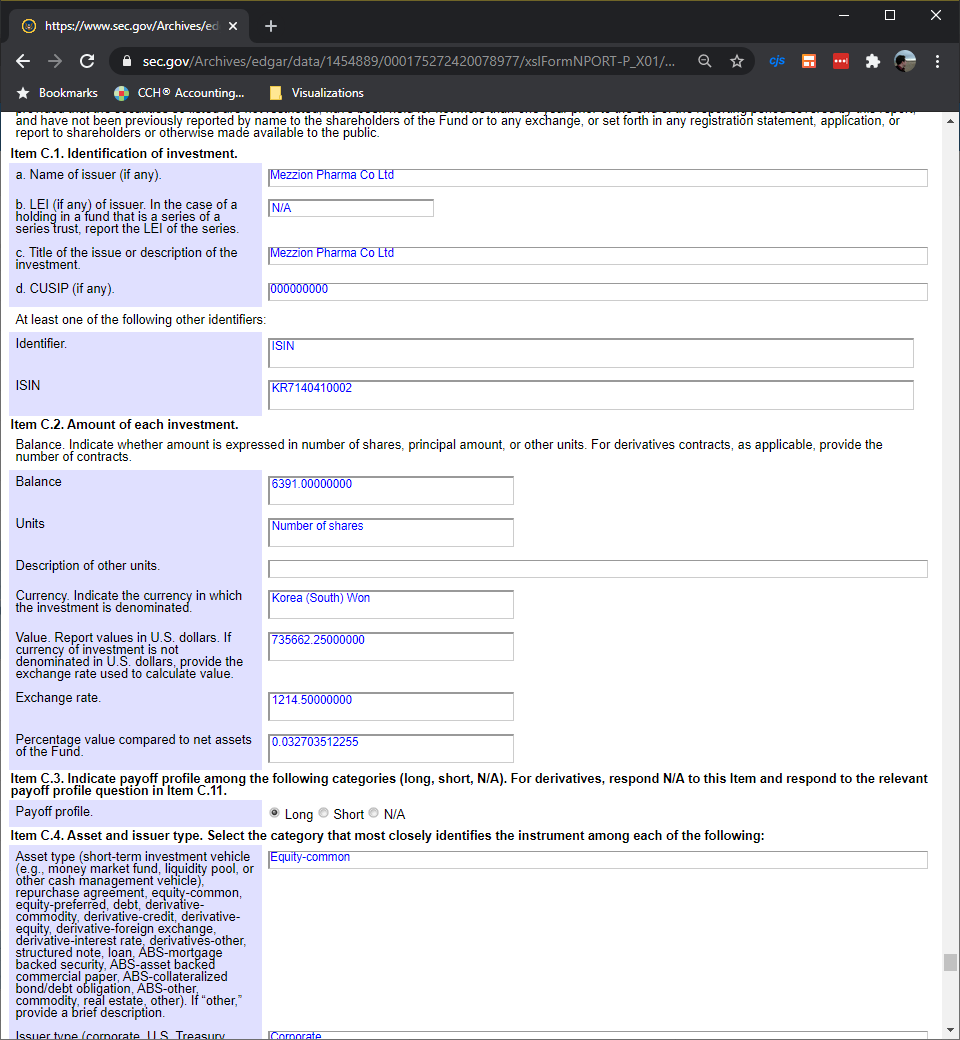

In [38]:
print(assetCat_sample[1])
assetCats['STIV'] = 'Short-term investment vehicle'

                                   name          title      Source assetCat
8819  BBH Cash Management Sweep Vehicle  TIME DEPOSITS  S000005912     STIV


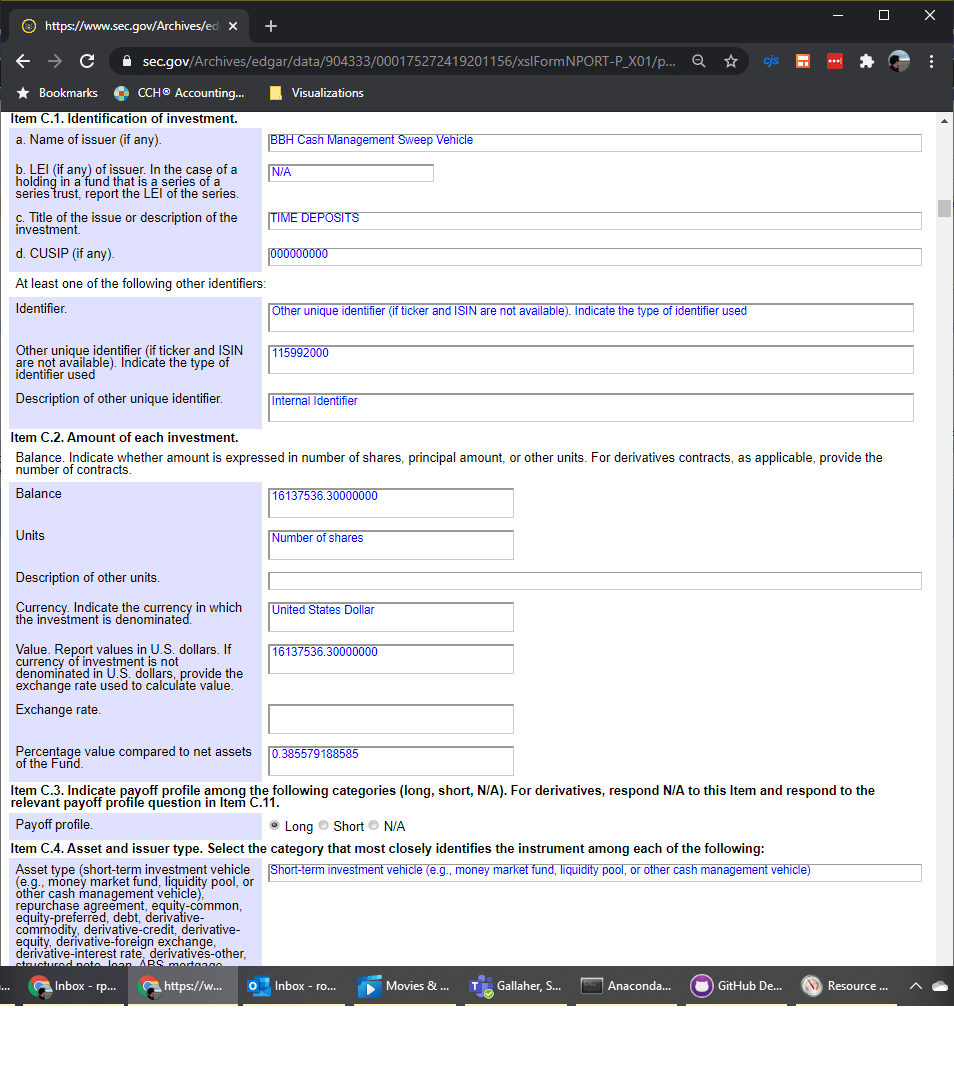

In [42]:
print(assetCat_sample[2])
assetCats['ABS-MBS'] = 'ABS-mortgage backed security'

                                     name  \
1519  BANC OF AMERICA FUNDING CORP 2007-C   

                                               title      Source assetCat  
1519  BANC OF AMERICA FUNDING CORPOR BAFC 2007 C 4A3  S000028928  ABS-MBS  


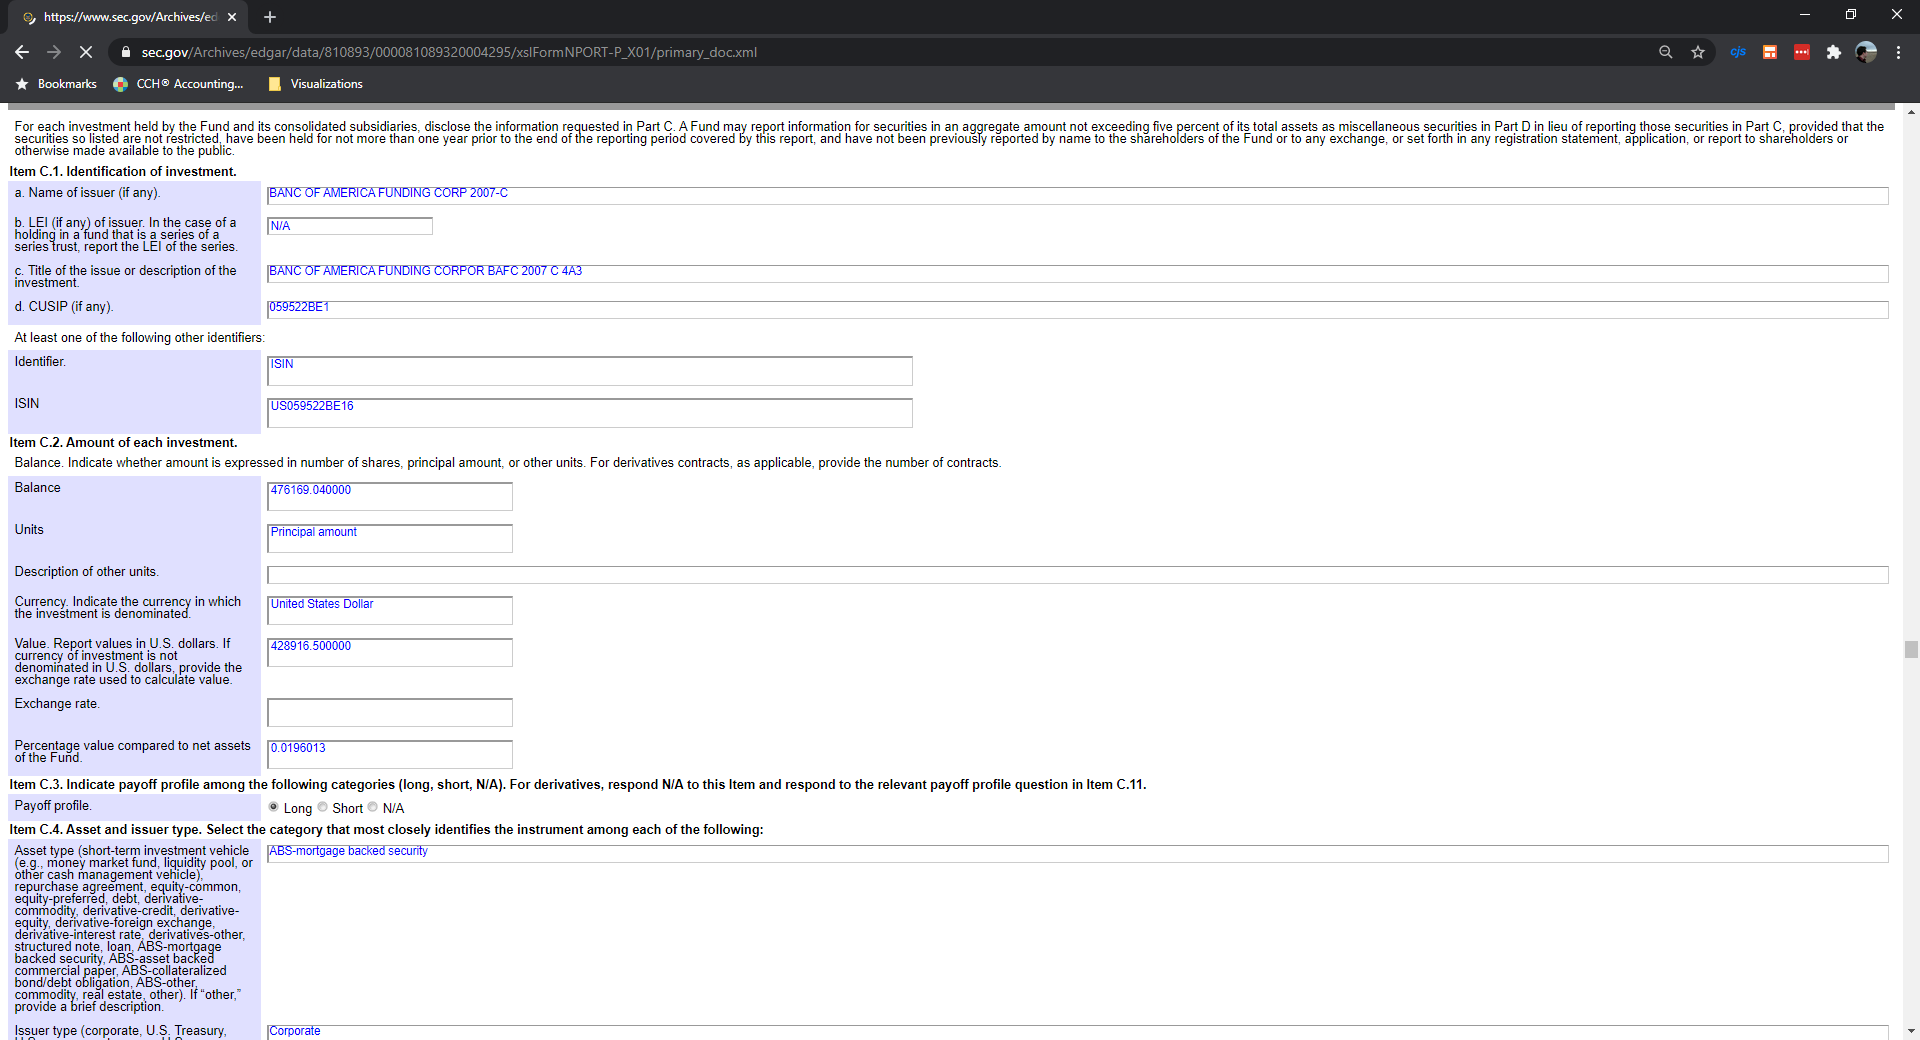

In [43]:
print(assetCat_sample[3])
assetCats['DIR'] = 'Derivative-interest rate'

     name                                  title      Source assetCat
2121  N/A  VARS GOLDLNPM 0.01782225 06/08/20 SOG  S000028928      DIR


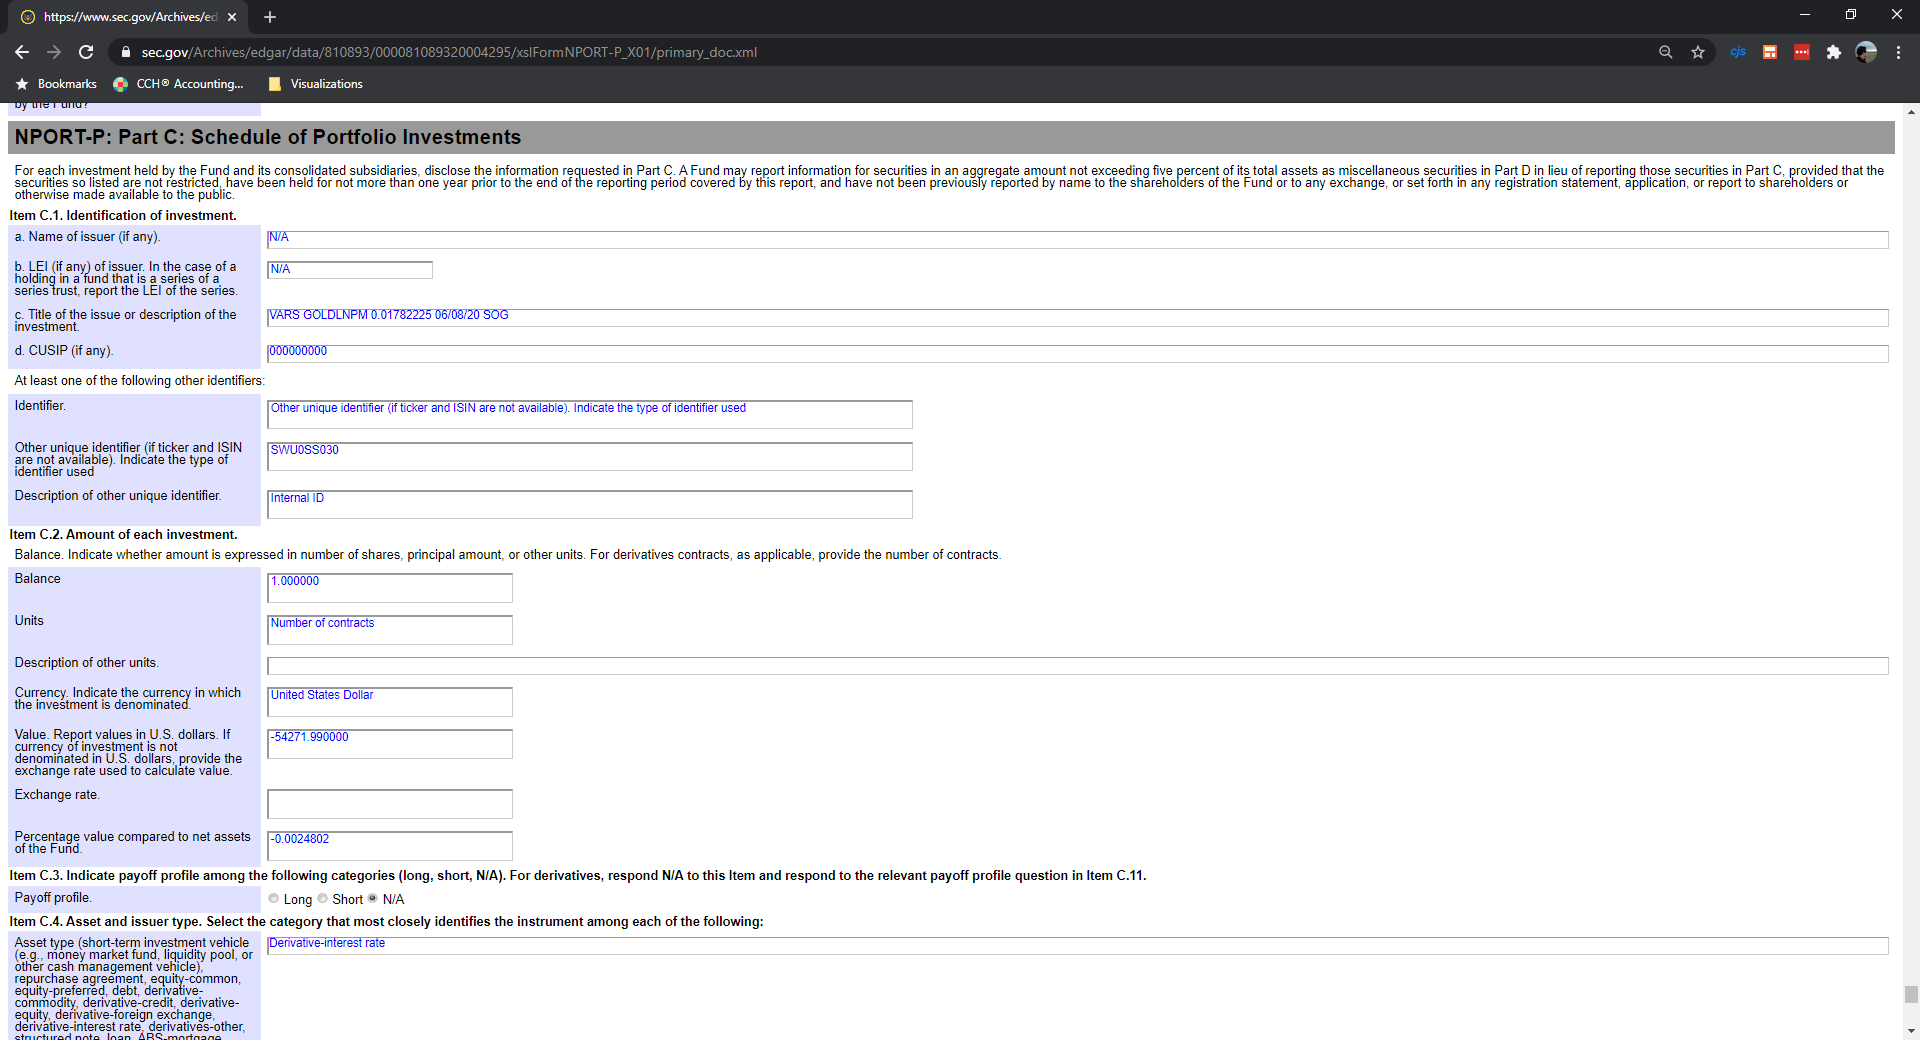

In [44]:
print(assetCat_sample[4])
assetCat['DBT'] = 'Debt'

                        name                       title      Source assetCat
1755  UNITED STATES TREASURY  U S TREASURY BILL 4/7/2020  S000028928      DBT


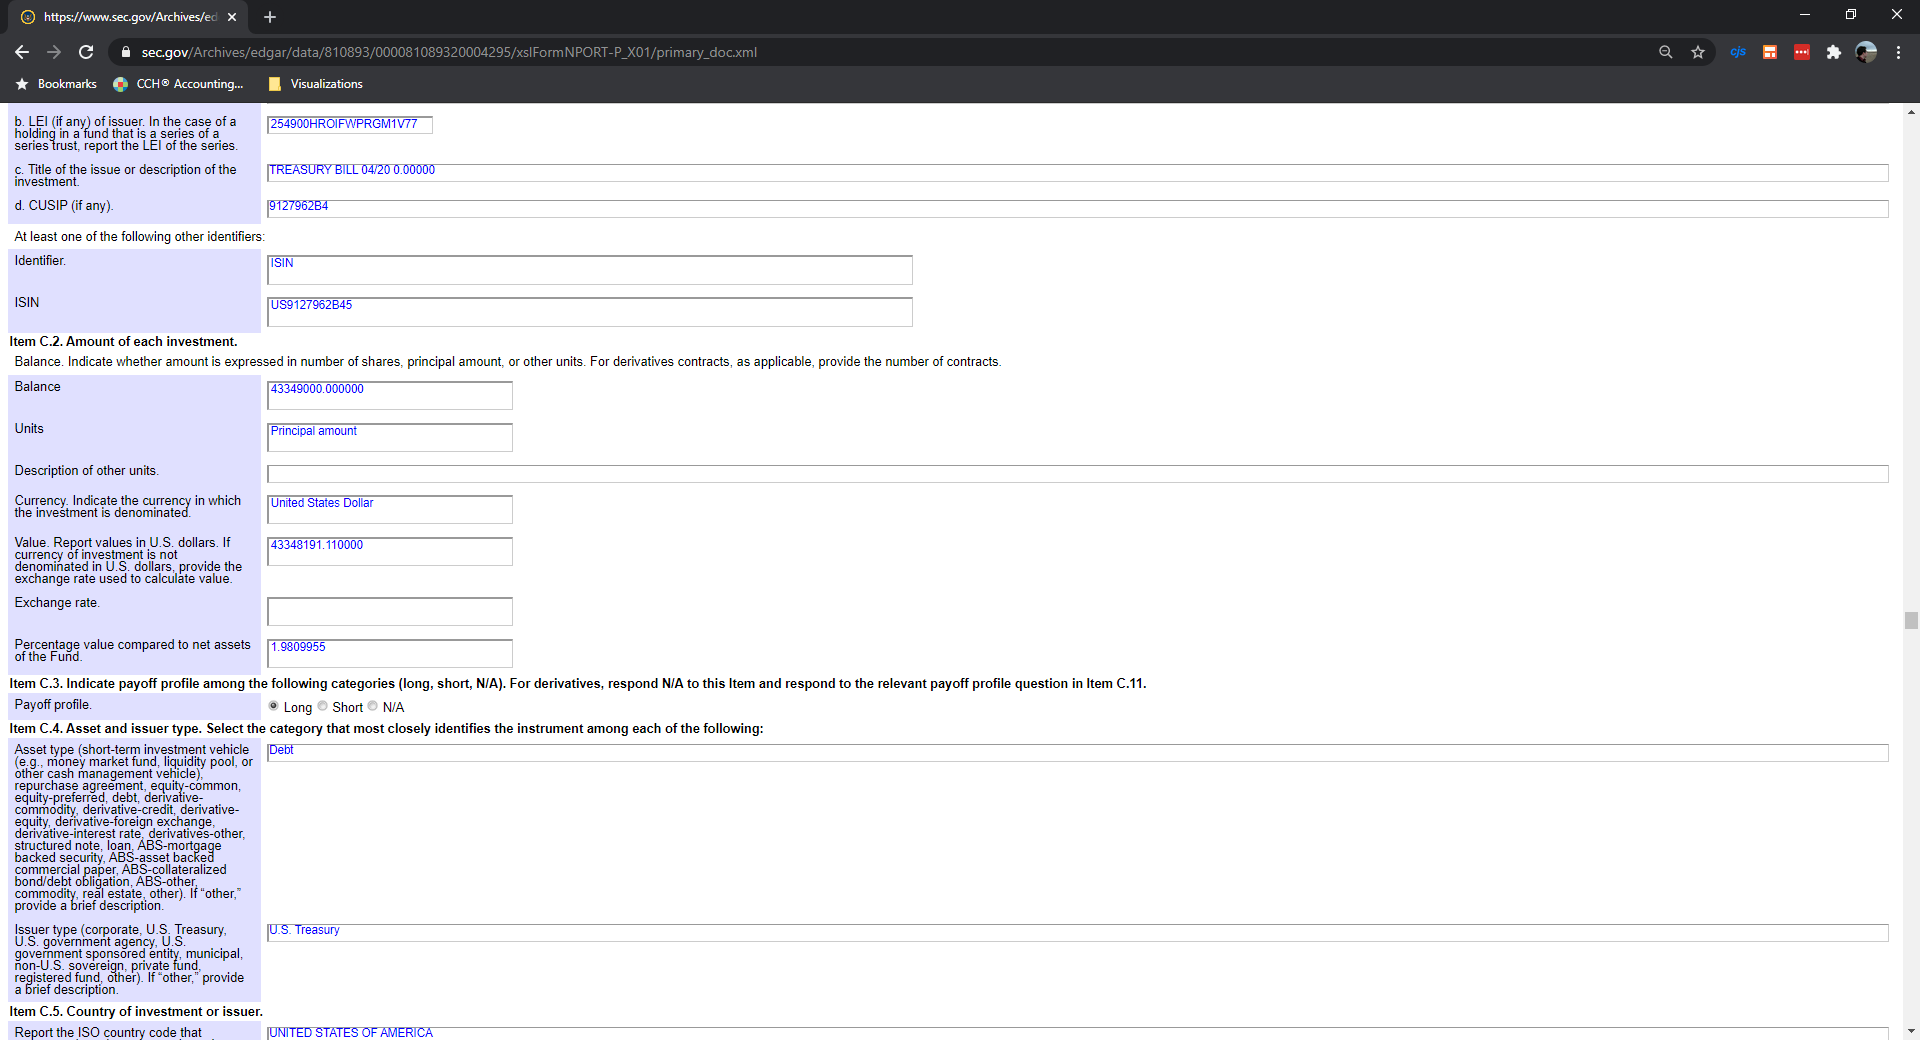

In [45]:
print(assetCat_sample[5])
assetCats['ABS-CBDO'] = 'ABS-collateralized bond/debt obligation'

                name                             title      Source  assetCat
1676  OCP CLO 2015-9  OCP CLO LTD OCP 2015 9A A1R 144A  S000028928  ABS-CBDO


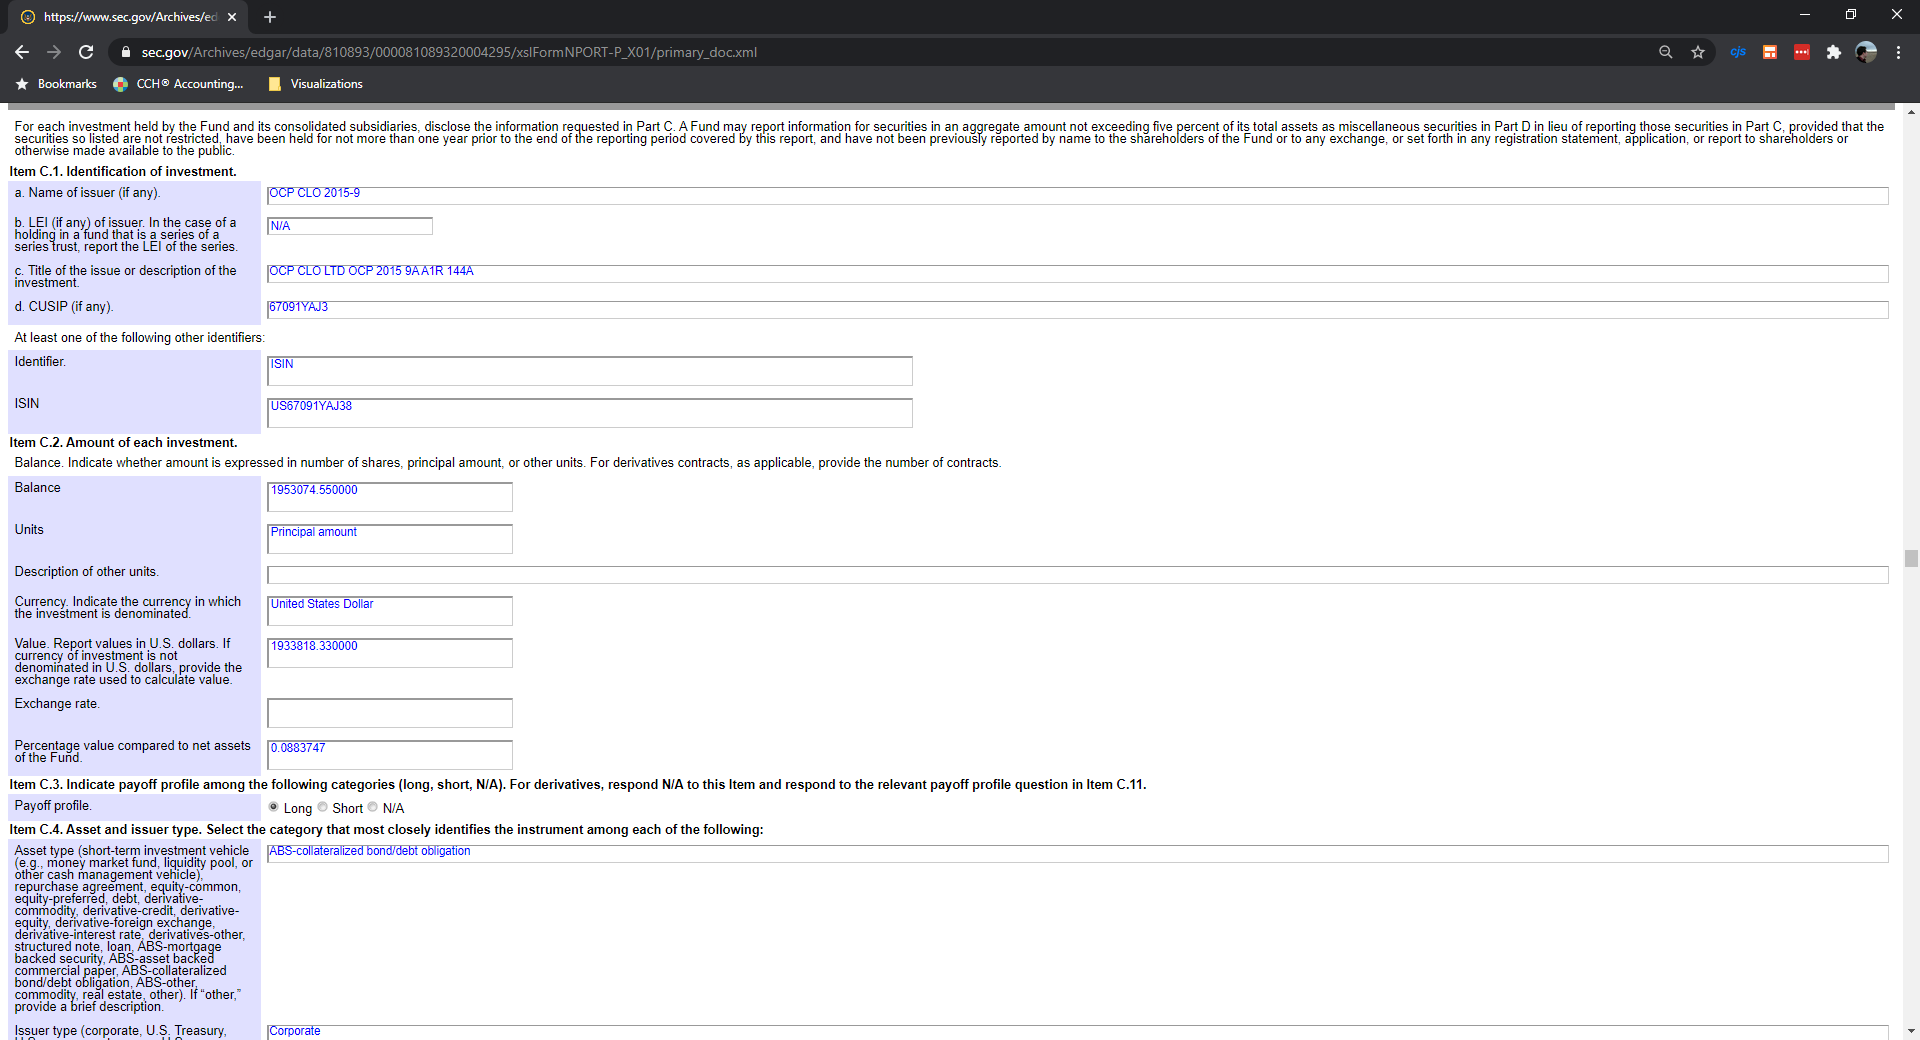

In [55]:
print(assetCat_sample[6])
assetCats['ABS-O'] = 'ABS-other'

                                        name  \
999  OSW STRUCTURED ASSET TRUST OSAT_20-RPL1   

                                 title      Source assetCat  
999  OSAT 20-RPL1 A1 144A FRN 12-01-59  S000030190    ABS-O  


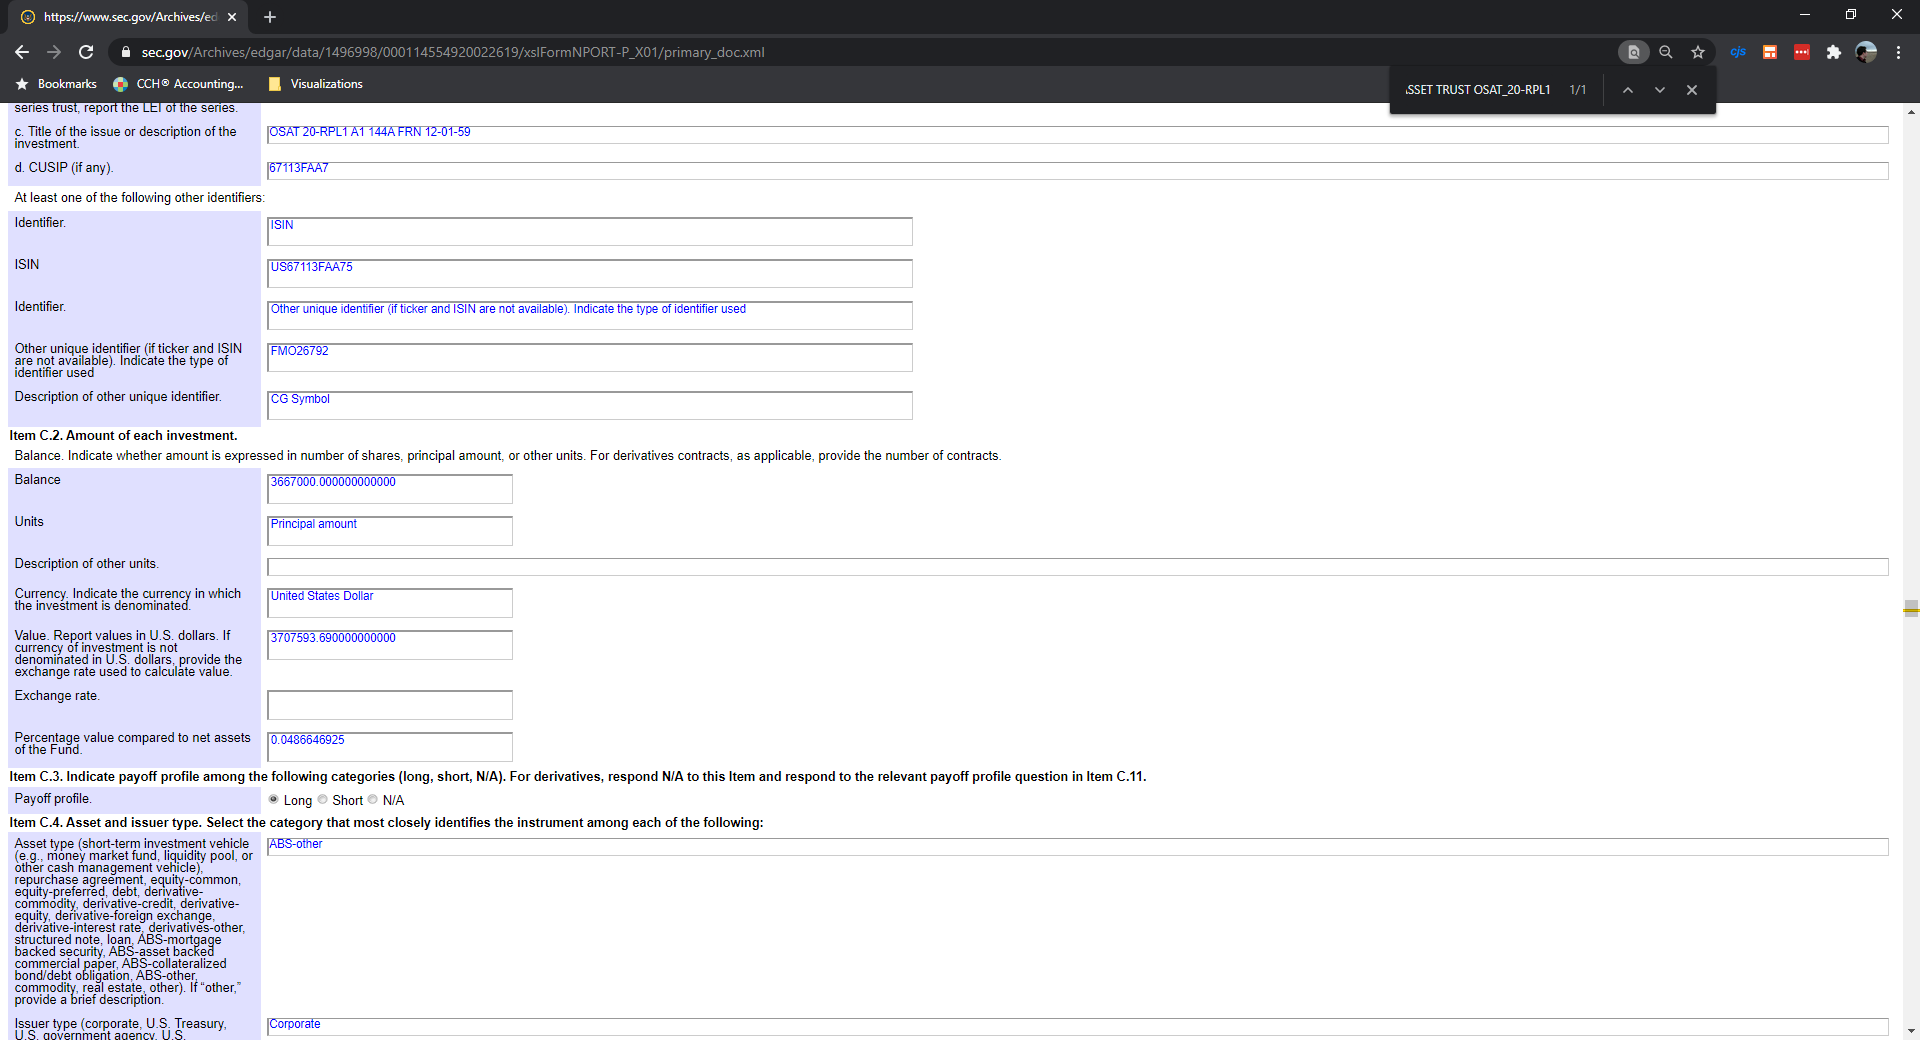

In [46]:
print(assetCat_sample[7])
assetCats['DFE'] = 'Derivative-foreign exchange'

     name                title      Source assetCat
1309  N/A  BOUGHT EUR/SOLD USD  S000028928      DFE


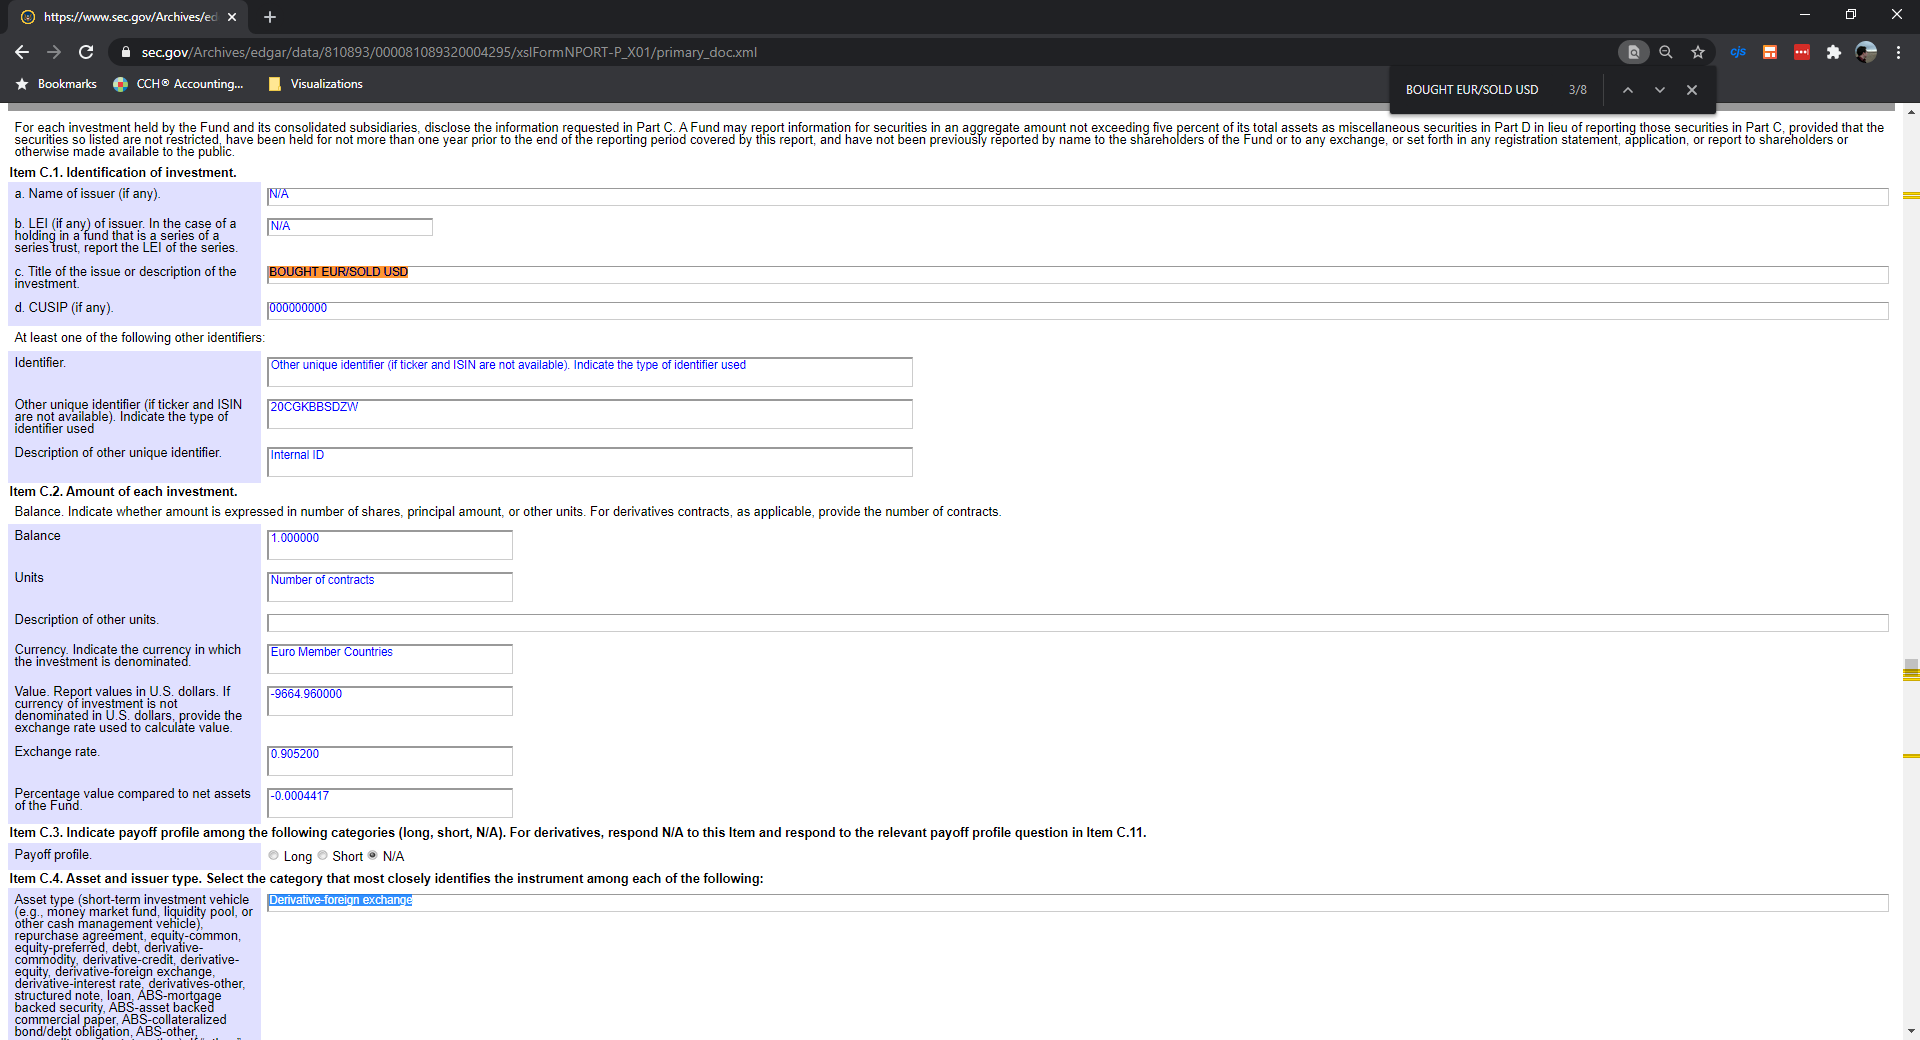

In [47]:
print(assetCat_sample[8])
assetCats['DCO'] = 'Derivative-commodity'


     name                                   title      Source assetCat
1376  N/A  COM FWD EUROBOBCO CAL20 6.15 12/20 GST  S000028928      DCO


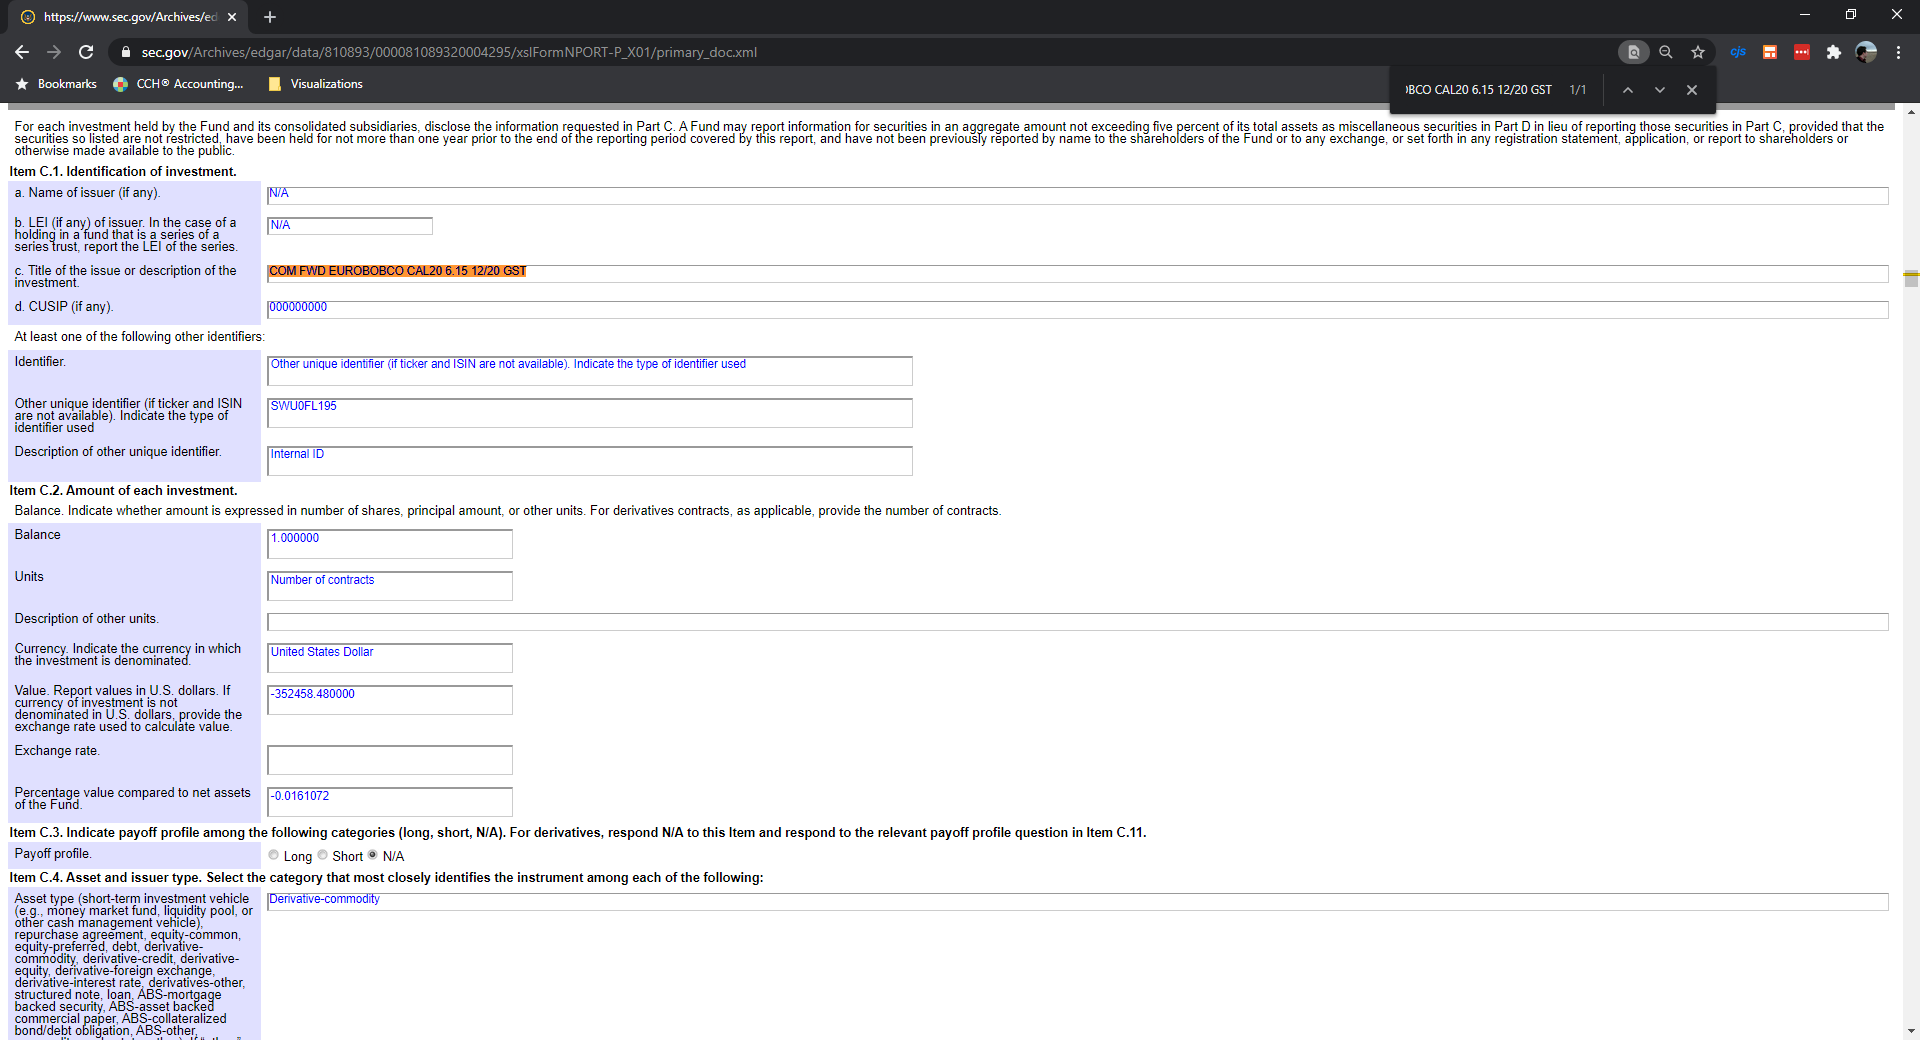

In [48]:
print(assetCat_sample[9])
assetCats['COMM'] = 'Commodity'

                             name                            title  \
1643  COMMODITY WAREHOUSE RECEIPT  SILVER CMX WR FAC 5001 HSBC BOS   

          Source assetCat  
1643  S000028928     COMM  


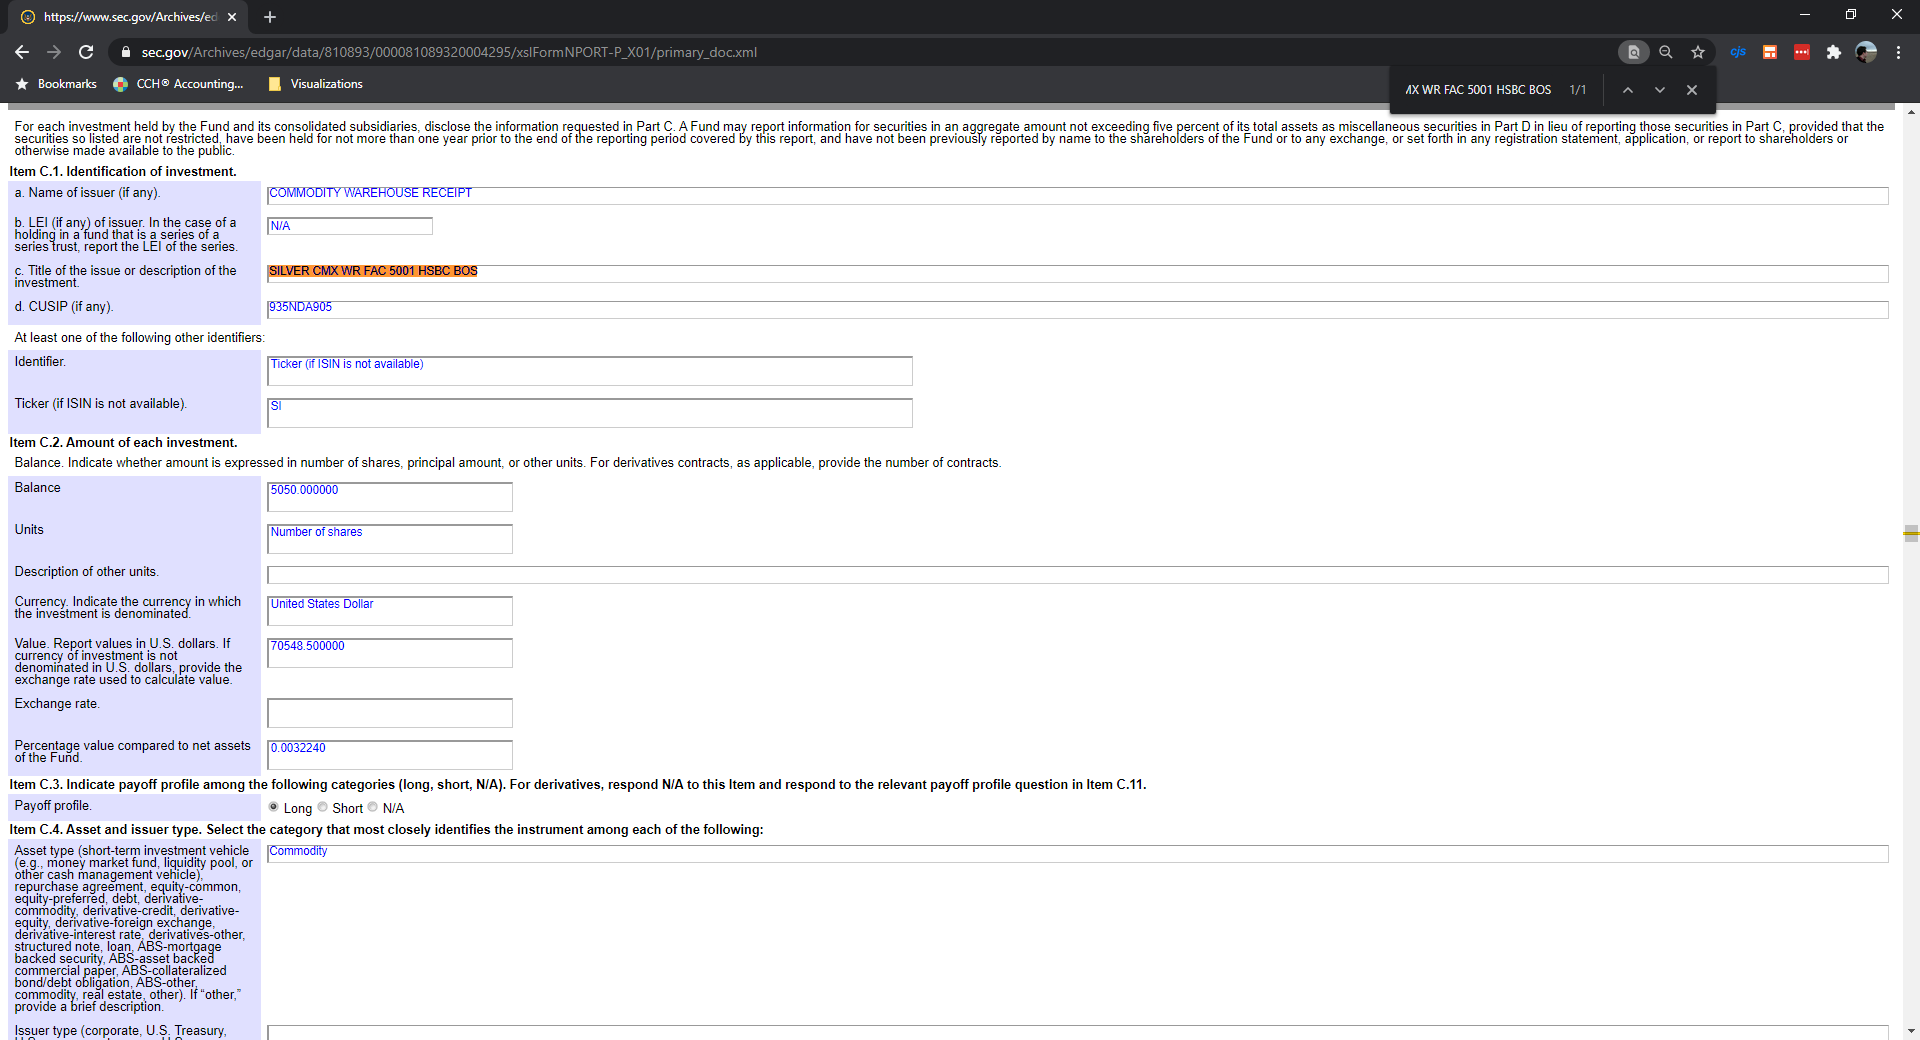

In [49]:
print(assetCat_sample[10])
assetCats['RA'] = 'Repurchase agreement'

     name                          title      Source assetCat
1811  N/A  RBC CAPITAL MARKETS REPO REPO  S000028928       RA


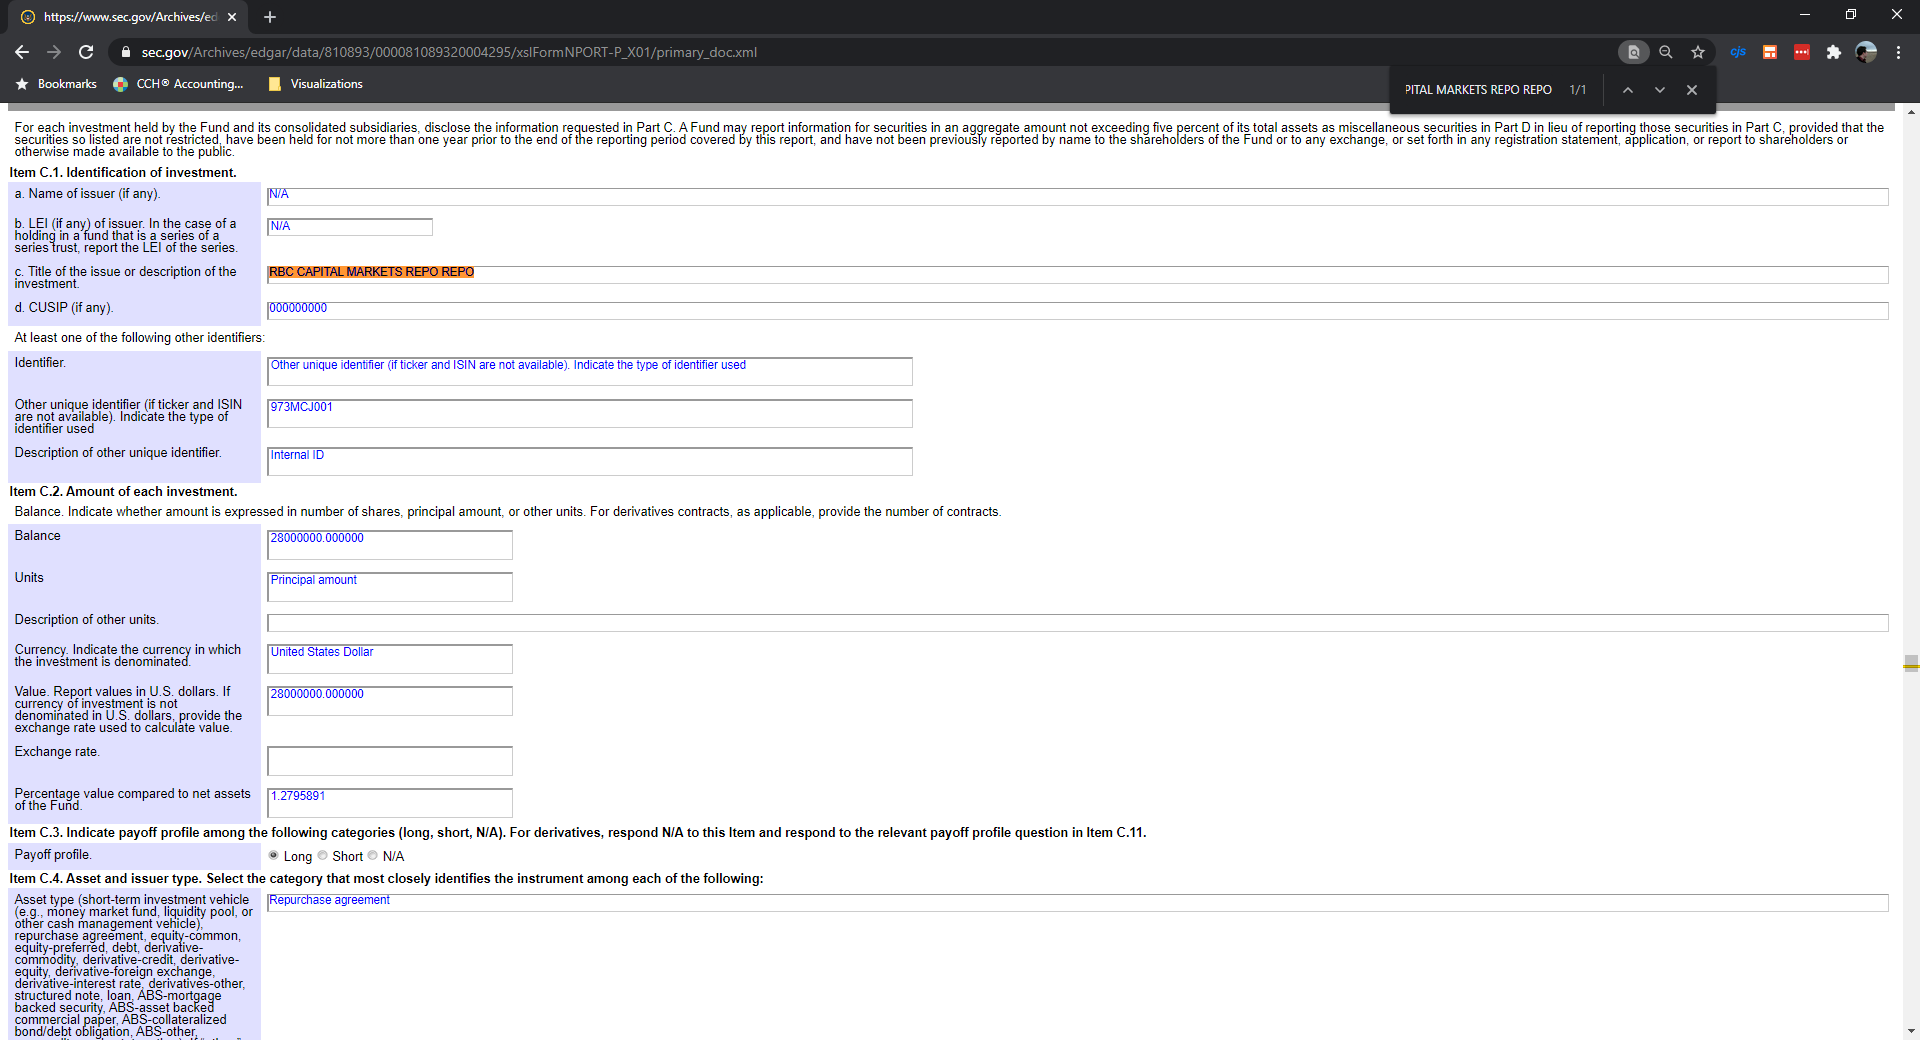

In [50]:
print(assetCat_sample[11])
assetCats['DCR'] = 'Derivative-credit'

     name                 title      Source assetCat
1906  N/A  CMBX.NA.AAA.7 SP MYC  S000028928      DCR


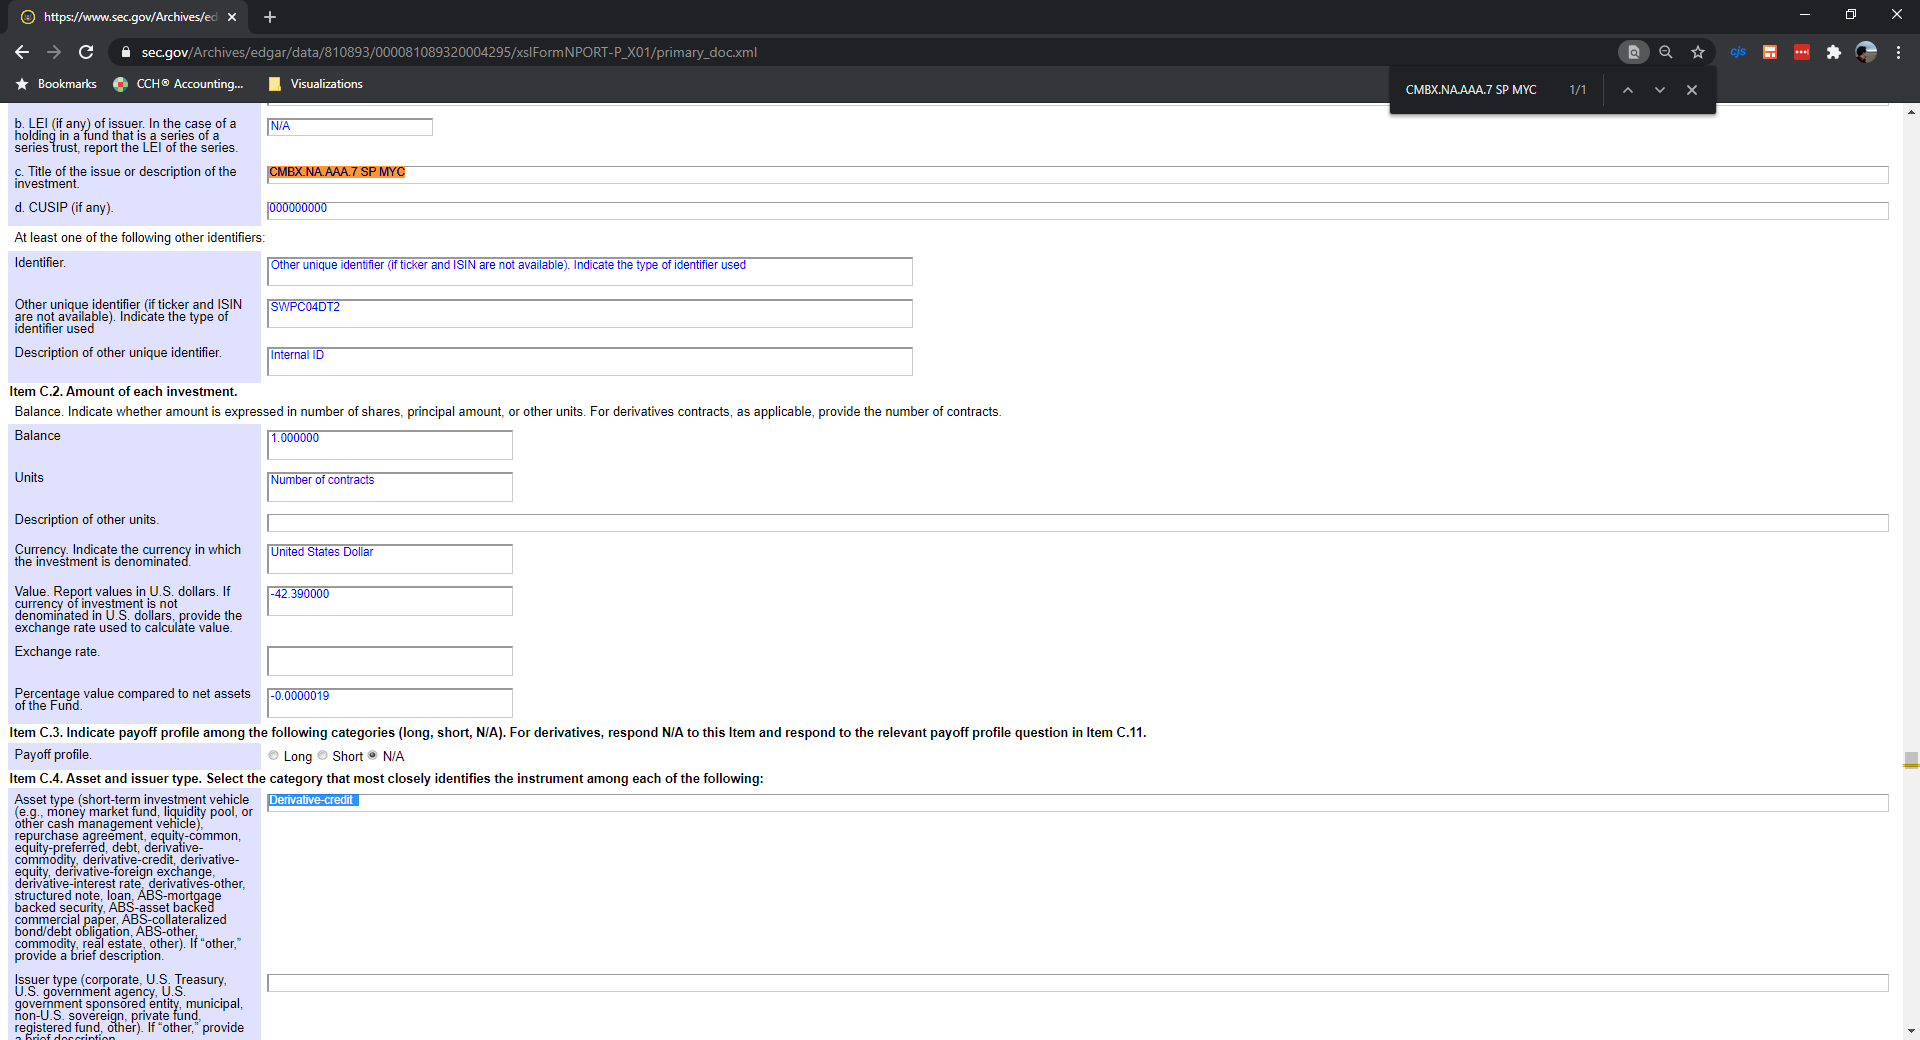

In [78]:
print(assetCat_sample[12])
assetCats['EP'] = 'Equity-preferred'

                   name              title      Source assetCat
4527  FUCHS PETROLUB SE  FUCHS PETROLUB SE  S000026637       EP


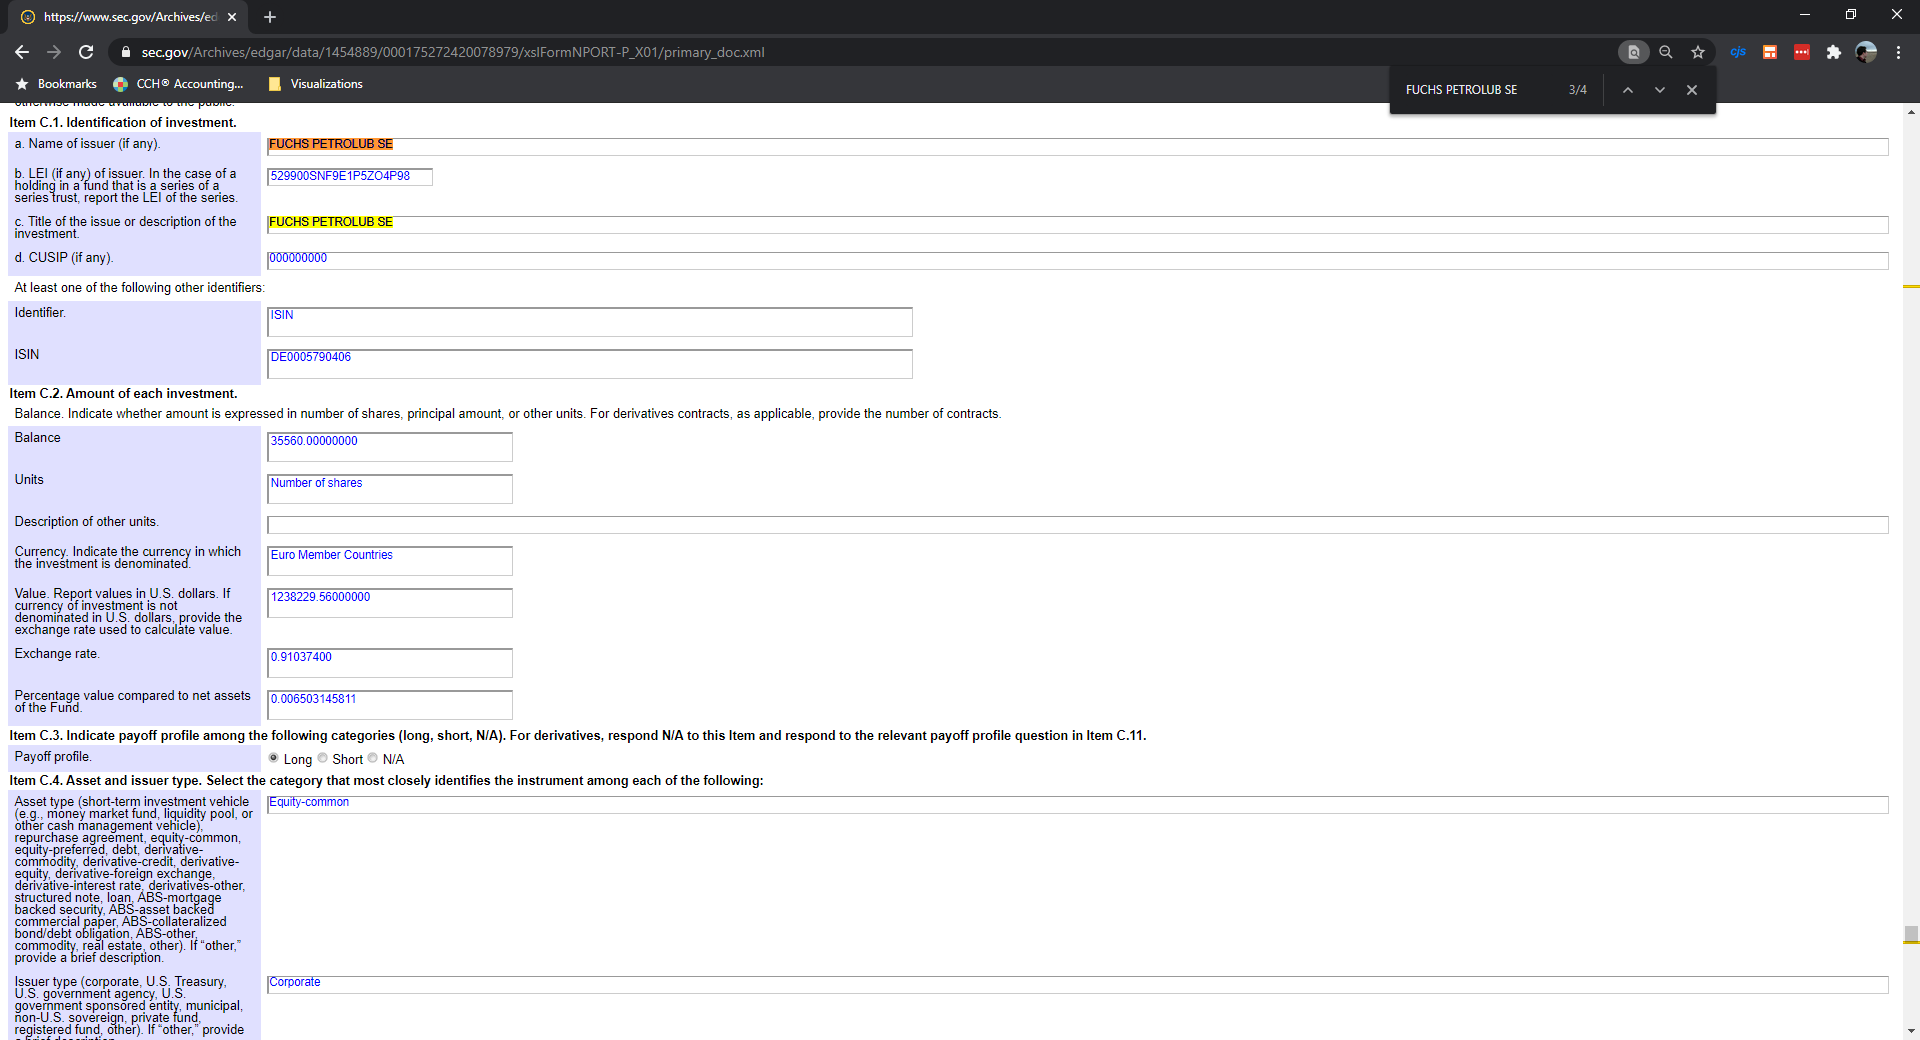

In [58]:
print(assetCat_sample[13])
assetCats['DE'] = 'Derivative-equity'

                                 name                             title  \
8209  CME CHICAGO MERCANTILE EXCHANGE  UST 30YR FUT ULTRA WNM0 06-19-20   

          Source assetCat  
8209  S000005911       DE  


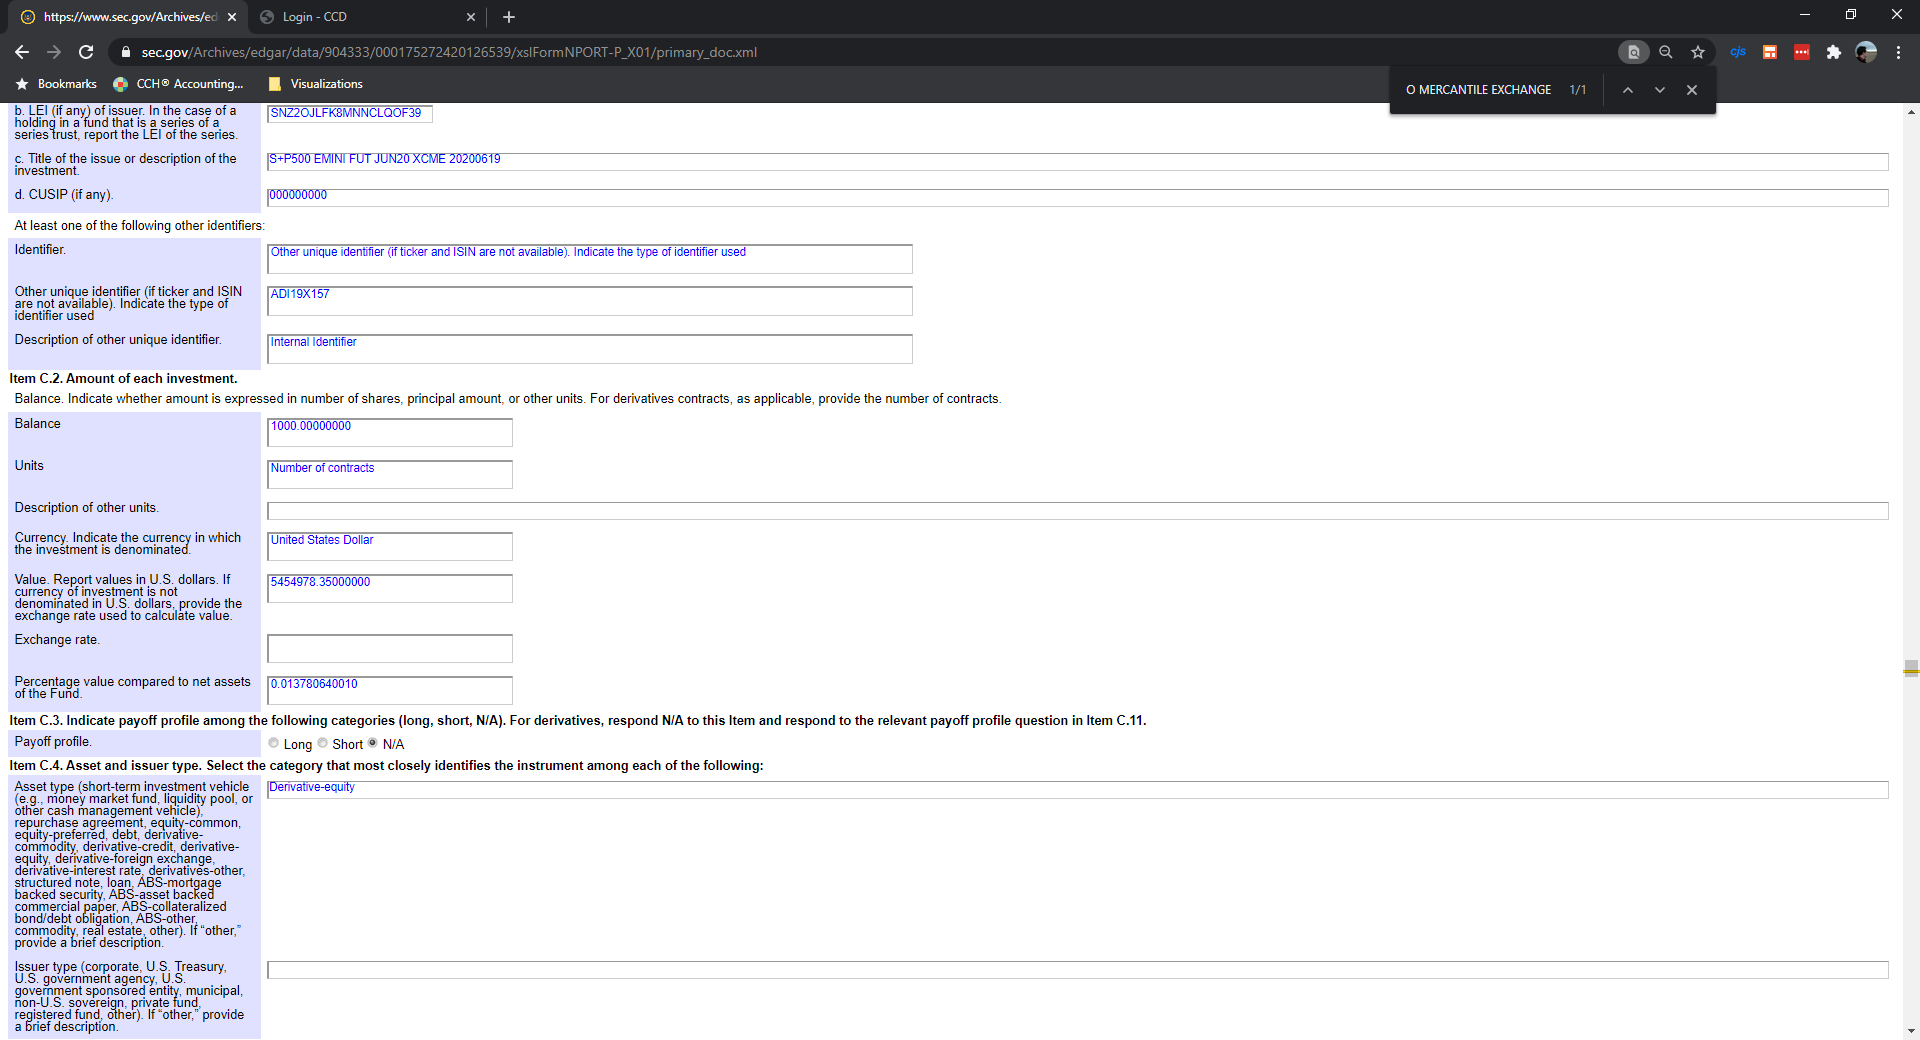

In [41]:
print(issuerCat_sample[0])
issuerCats['CORP'] = 'Corporate'

               name          title      Source issuerCat
2677  Ryosan Co Ltd  Ryosan Co Ltd  S000026638      CORP


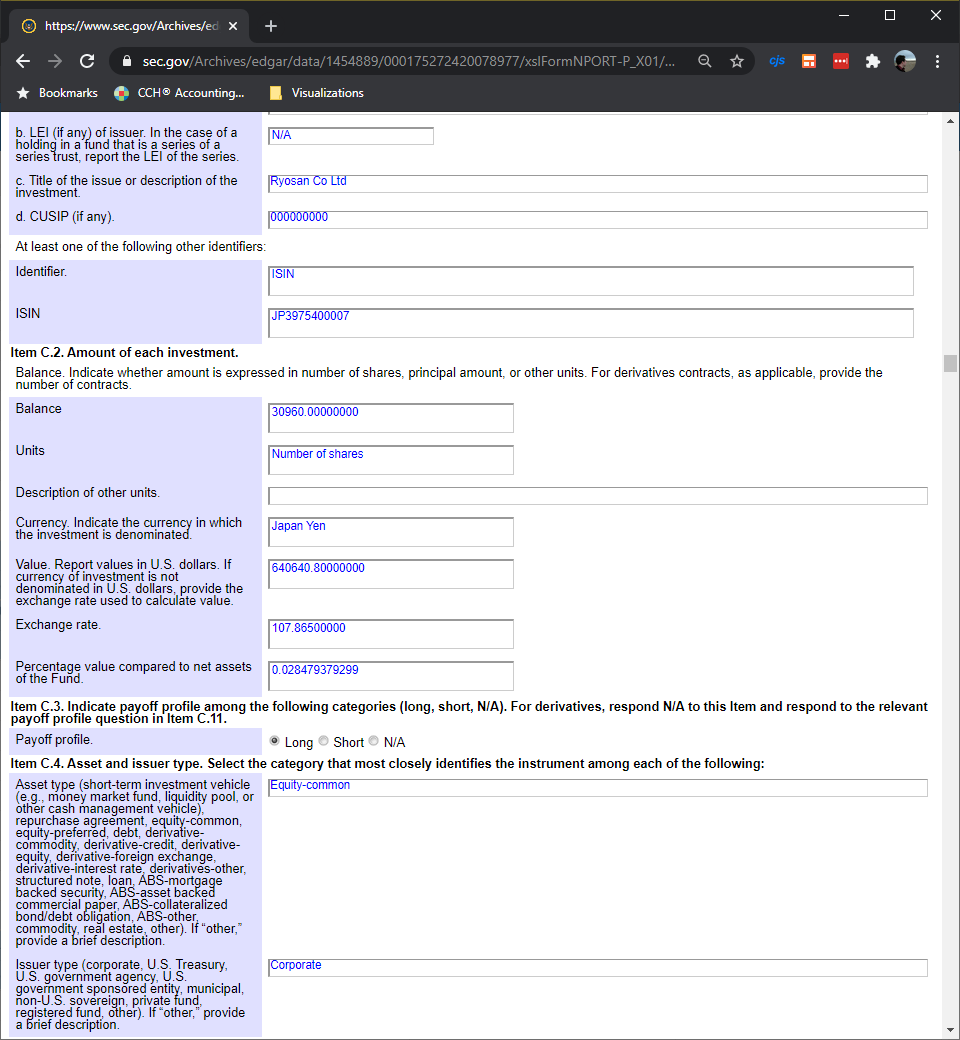

In [60]:
print(issuerCat_sample[1])
issuerCats['RF'] = 'Registered fund'

                                          name  \
7093  Wells Fargo Government Money Market Fund   

                                         title      Source issuerCat  
7093  Wells Fargo Government Money Market Fund  S000026634        RF  


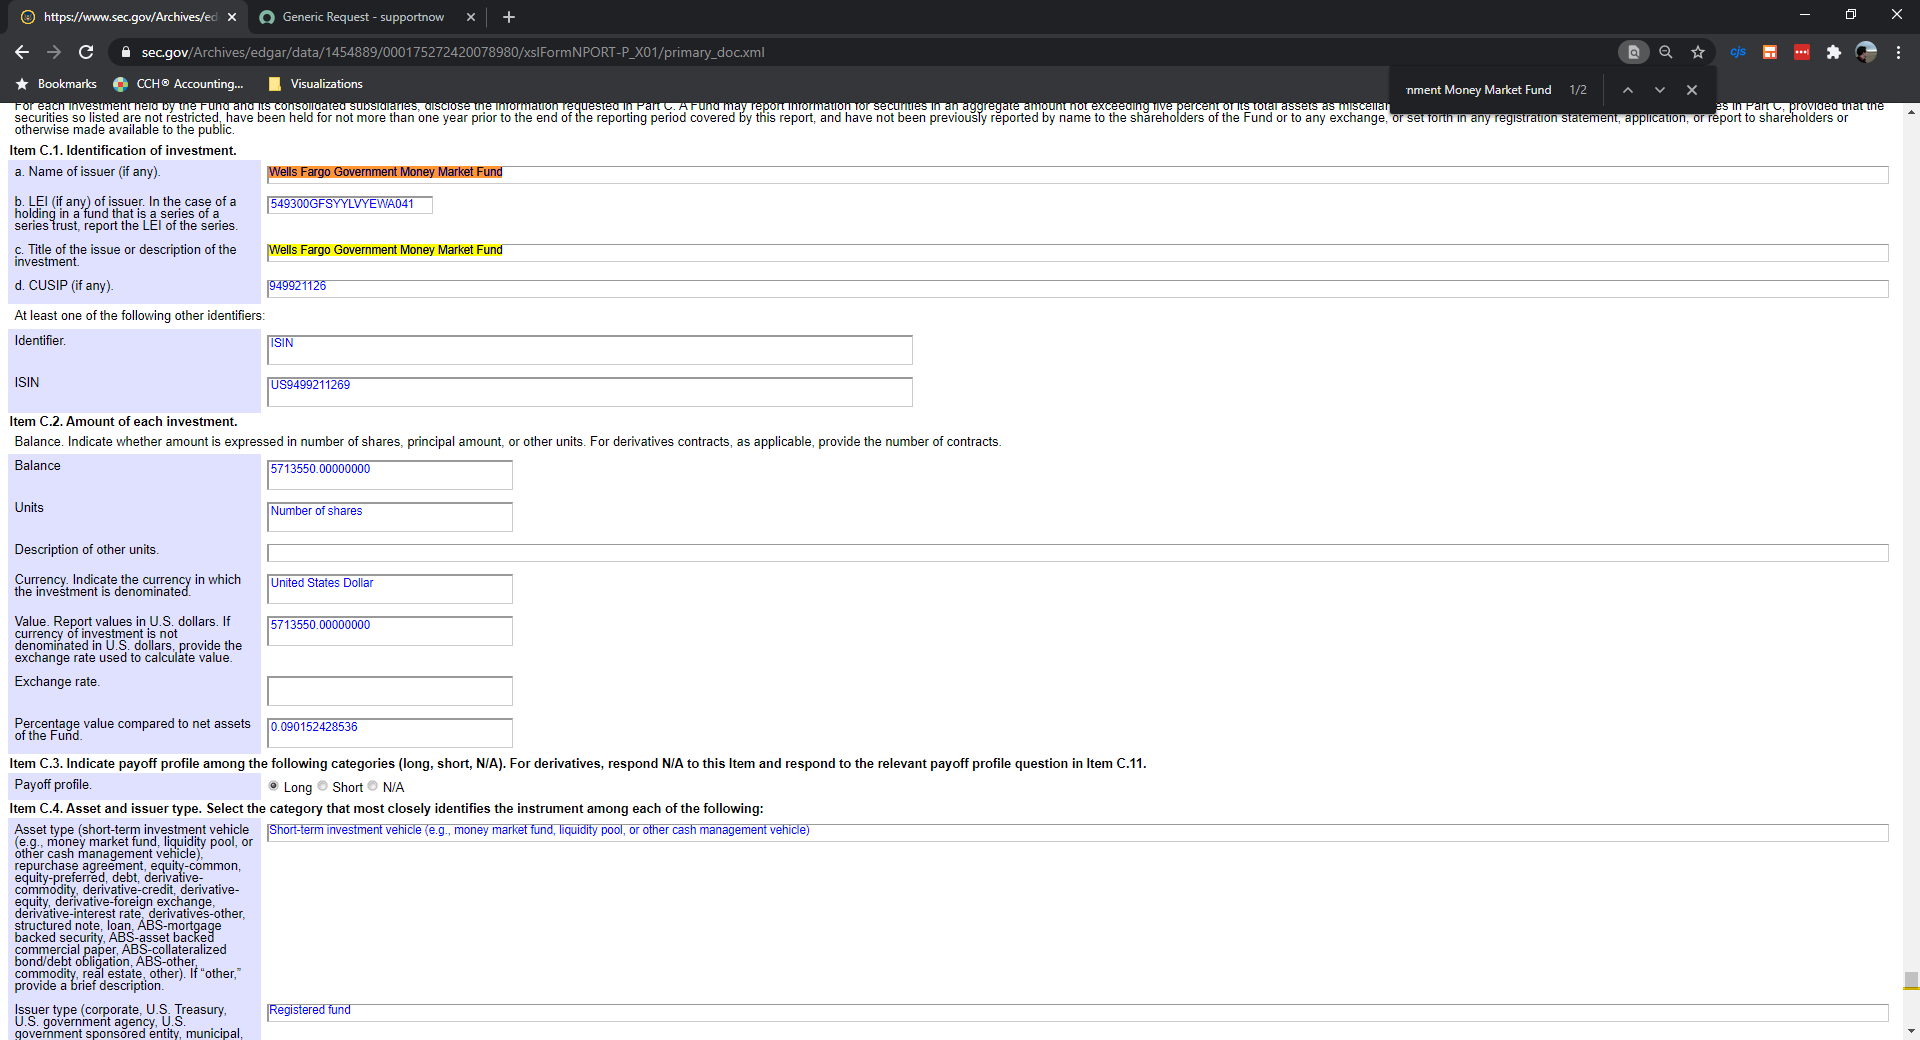

In [61]:
print(issuerCat_sample[2])
issuerCats['NUSS'] = 'Not Specified'

                                    name  \
128  Bank Rakyat Indonesia (Persero) Tbk   

                                         title      Source issuerCat  
128  Bank Rakyat Indonesia (Persero) Tbk IDR50  S000004201      NUSS  


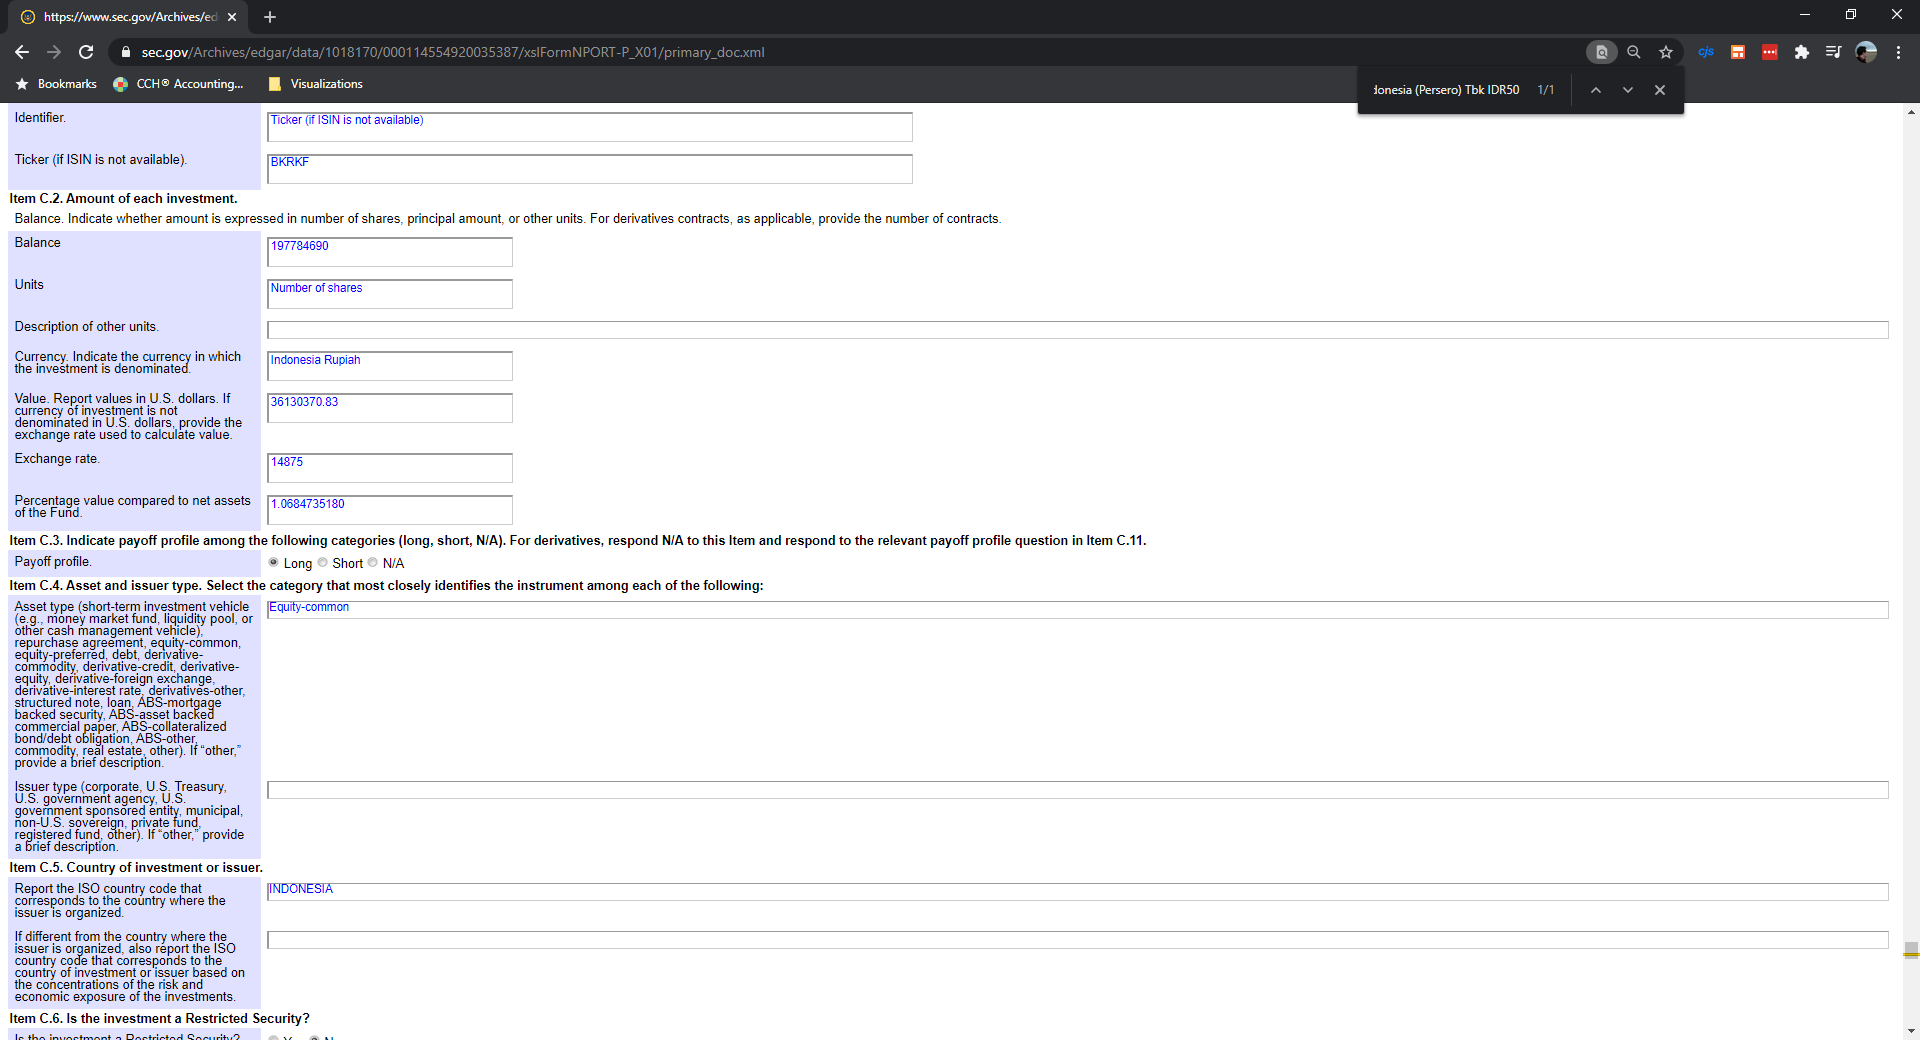

In [32]:
issuerCat_sample[3]

'Unable to sample nan'

In [54]:
print(issuerCat_sample[4])
issuerCats['USGA'] = 'U.S. government agency'

                                           name  \
952  GOVERNMENT NATIONAL MORTGAGE ASSOCIATION I   

                                  title      Source issuerCat  
952  GNSF 2.75 AB1591 175K MAX 09-15-42  S000030190      USGA  


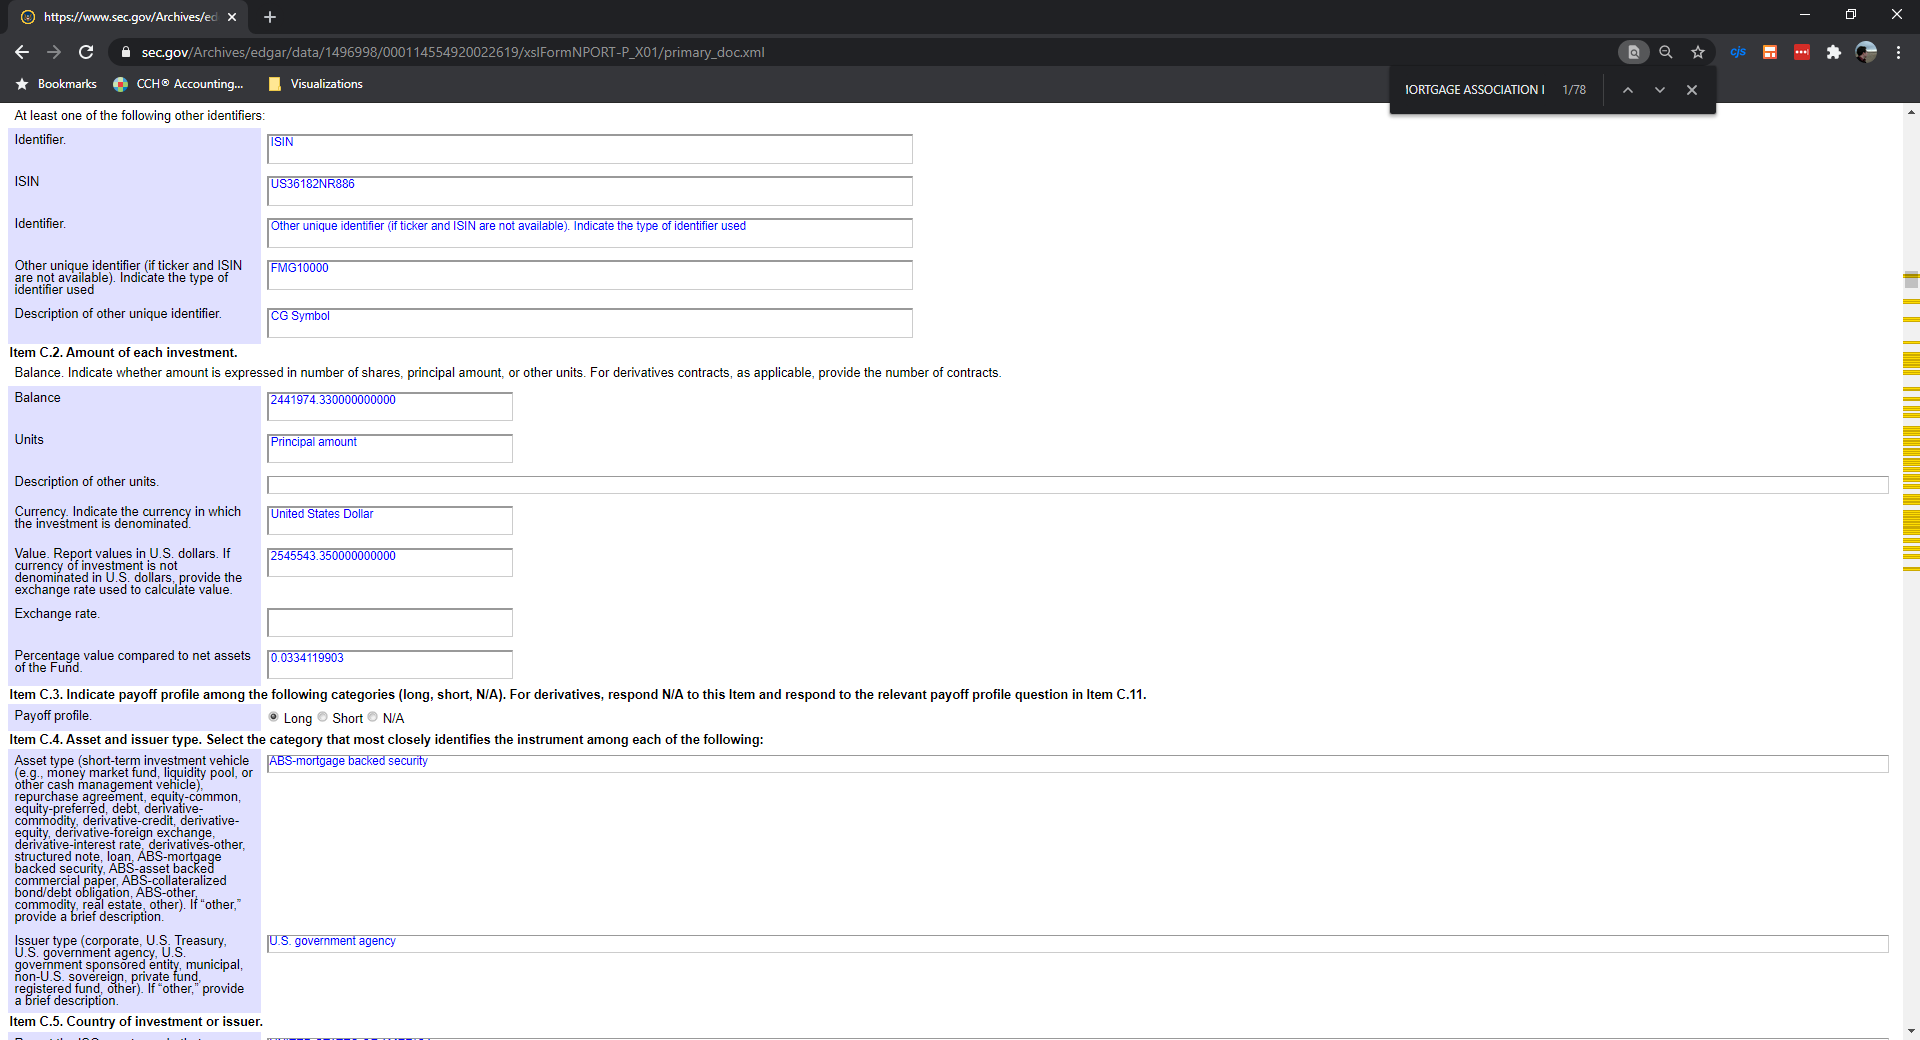

In [59]:
print(issuerCat_sample[5])
issuerCats['UST'] = 'U.S. Treasury'

                    name                        title      Source issuerCat
1784  UNITED STATES GOVT  TSY INFL IX N/B 07/27 0.375  S000028928       UST


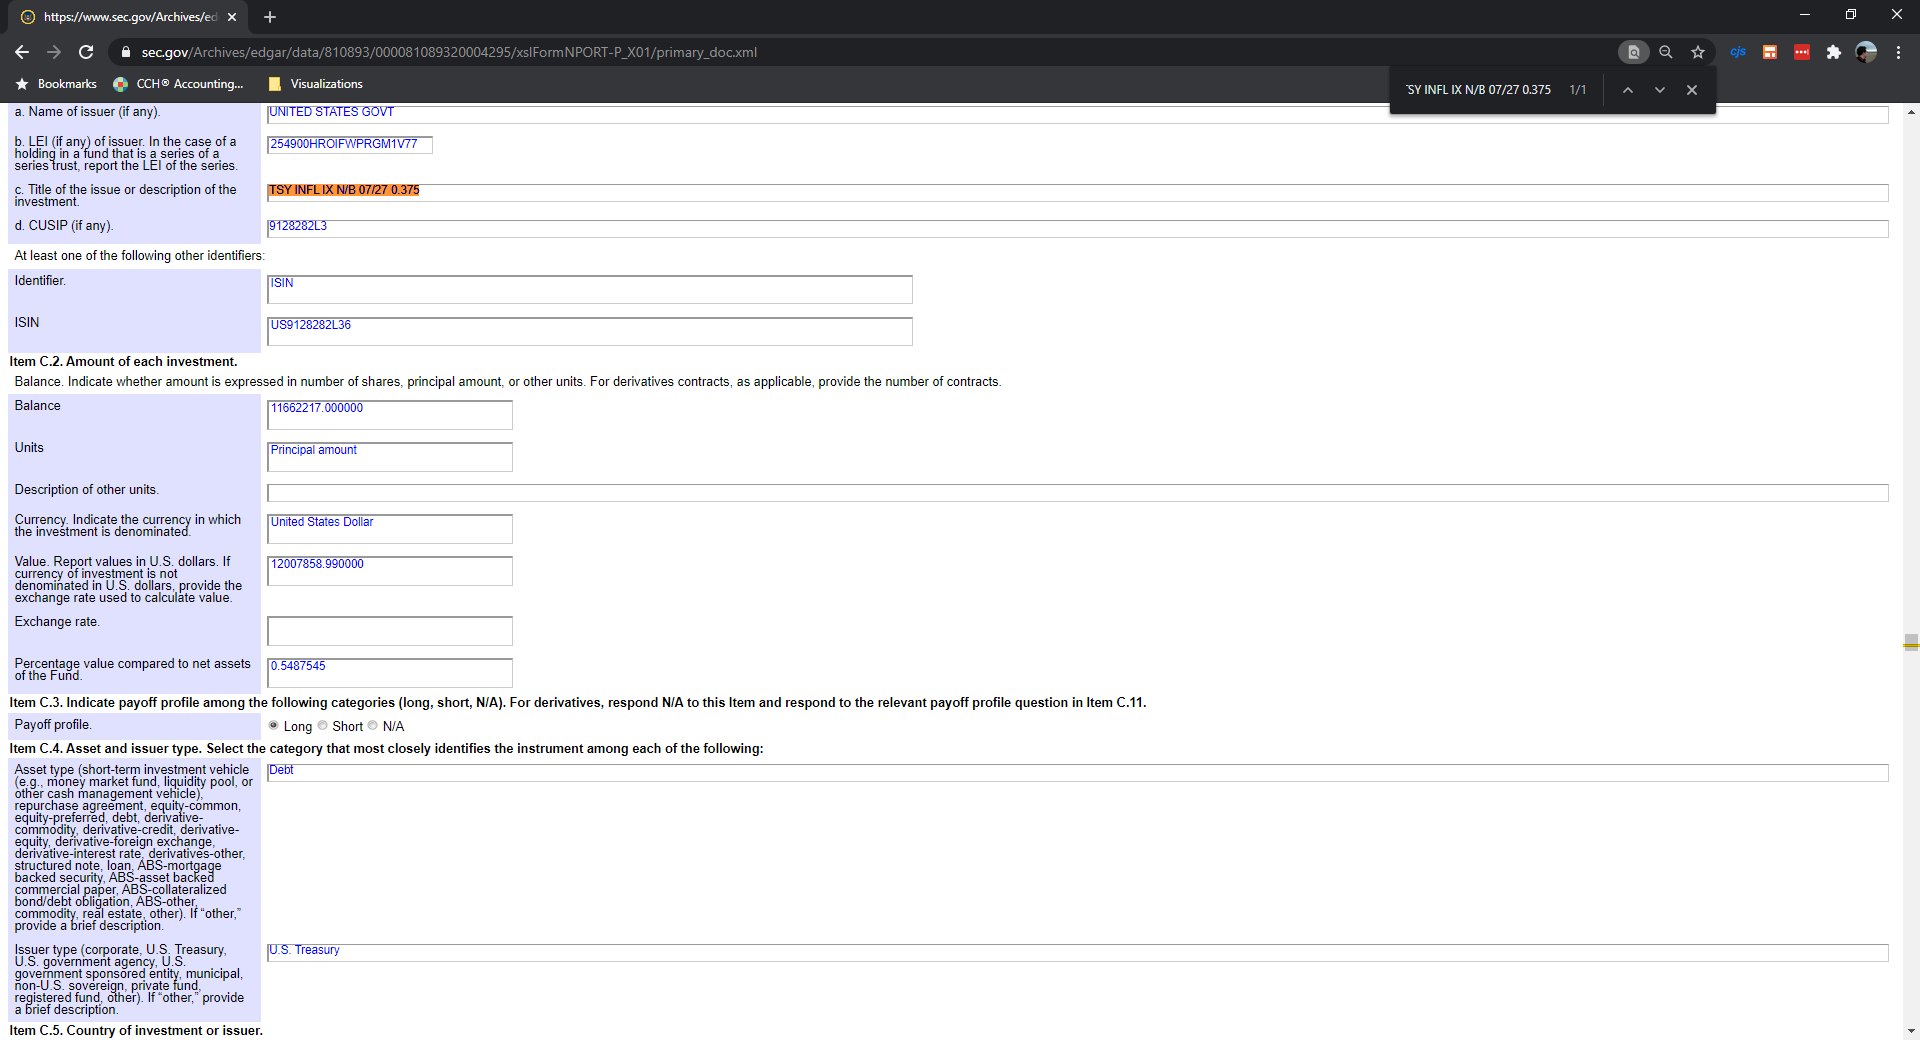

In [52]:
print(issuerCat_sample[6])
issuerCats['USGSE'] = 'U.S. government sponsored entity'

                    name                      title      Source issuerCat
1579  FANNIE MAE 2006-98  FANNIE MAE FNR 2006 98 FA  S000028928     USGSE


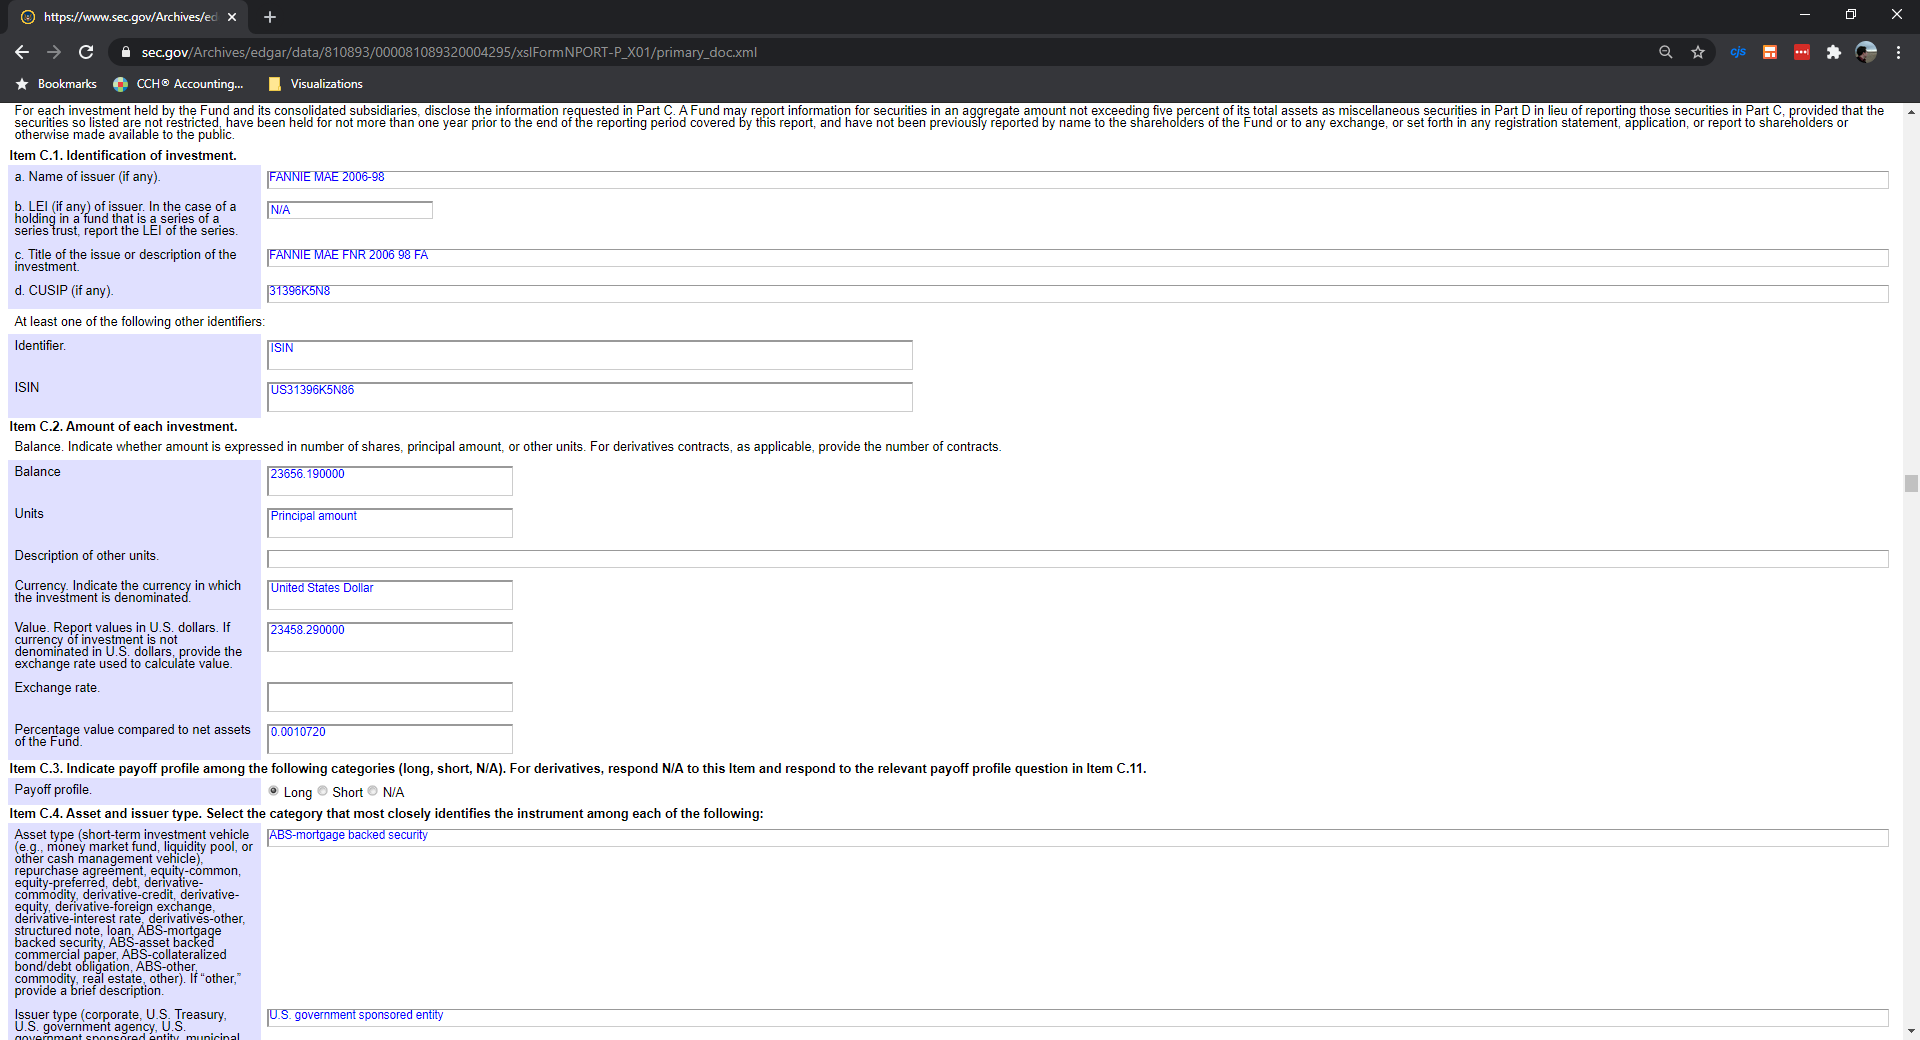

In [53]:
print(issuerCat_sample[7])
issuerCats['MUN'] = 'Municipal'

                                                   name  \
1673  NORTH CAROLINA STATE EDUCATION ASSISTANCE AUTH...   

                                              title      Source issuerCat  
1673  NORTH CAROLINA STATE EDUCATION NCSEA 2012 1 A  S000028928       MUN  


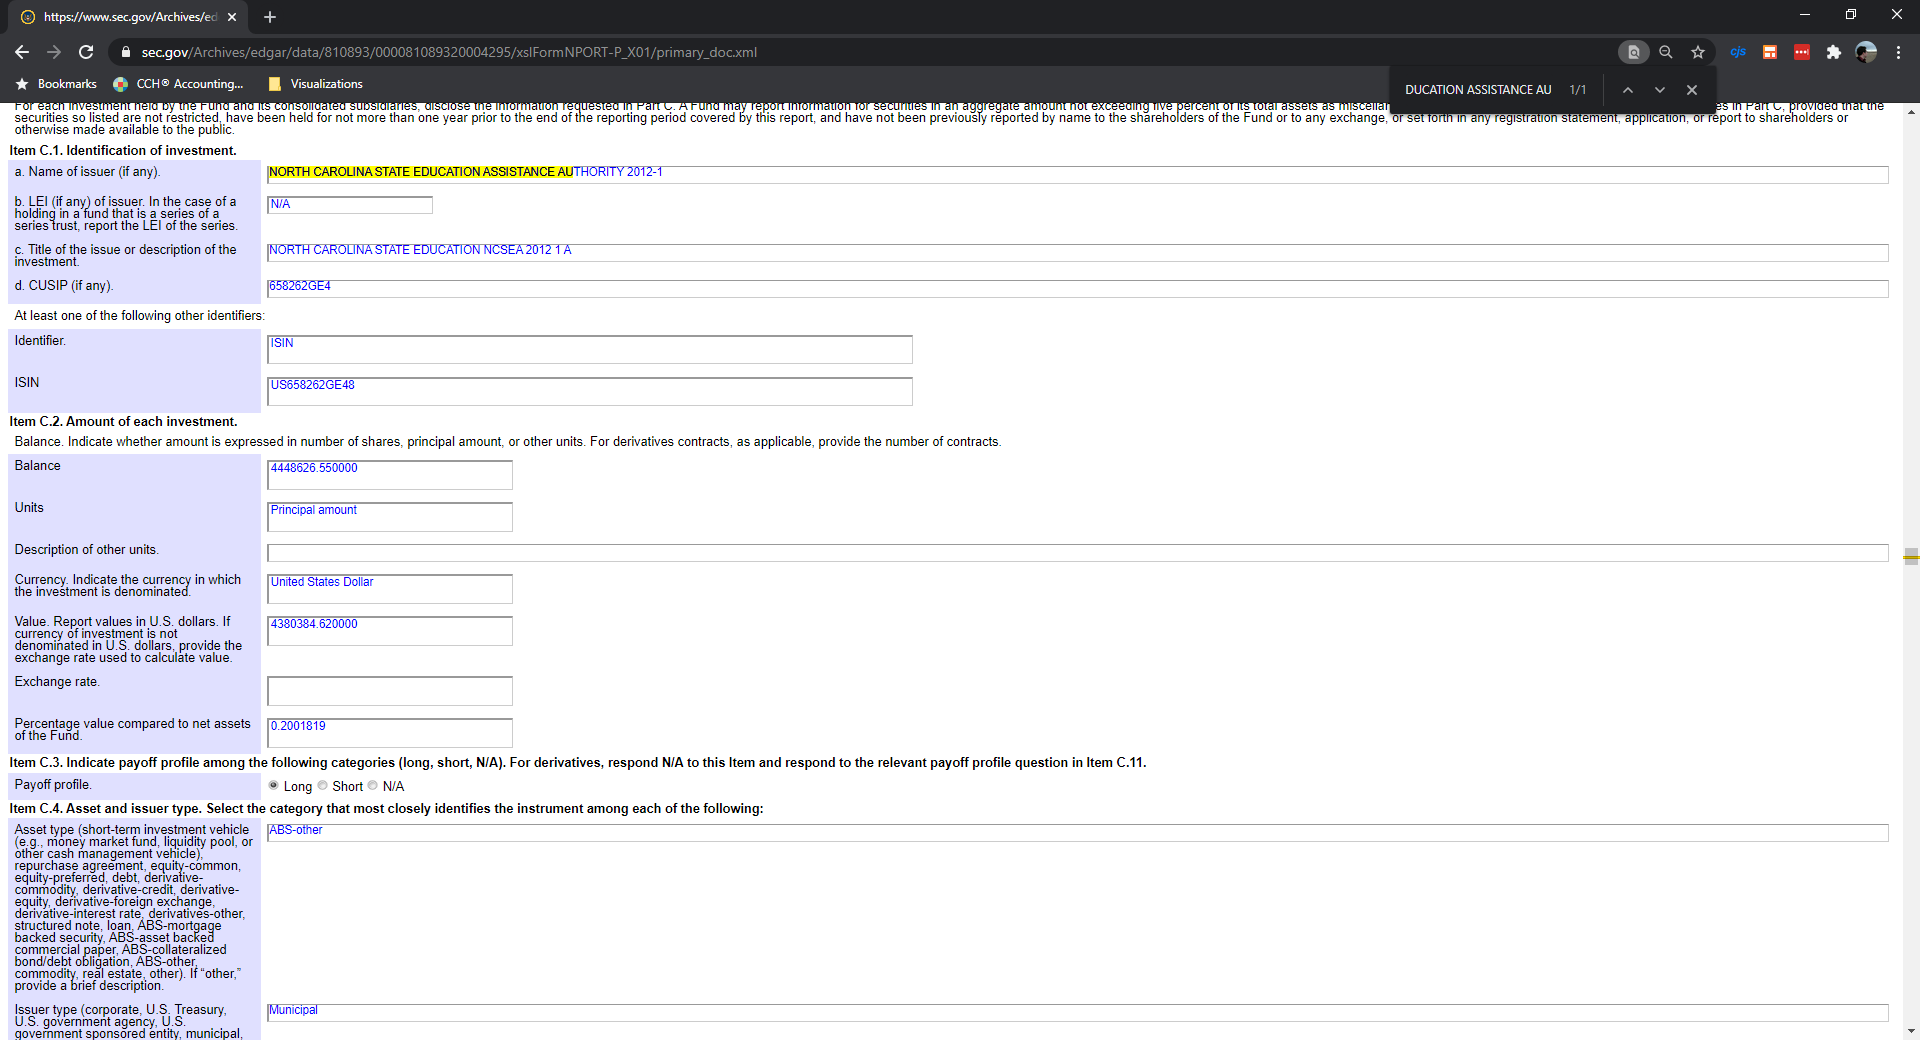

### Visualization 1: Sankey Diagram

In [9]:
basic_view = ['Source','PortfolioValue',
    'lei','cusip','cusip_clean','payoffProfile','assetCat',
    'issuerCat','invCountry','isRestrictedSec','fairValLevel',
]

## This code ensures all CUSIPs have consistent information

mask = ~holds.all_NPORT['cusip_clean'].duplicated()
names = holds.all_NPORT[mask][['cusip_clean','name','title']]

basic_cusip = holds.all_NPORT[basic_view].merge(names,on='cusip_clean',how='left')

basic_cusip = basic_cusip.merge(secs[['series_name','series_id']],
                                left_on='Source',
                                right_on='series_id',
                                how='left')

In [76]:
sankey = basic_cusip.groupby(['assetCat','series_name'],as_index=False)['PortfolioValue'].sum()

# Plotly uses only numbers for sankeys so I need to make indices to correspond with lables

labels = list(sankey['assetCat'].unique()) + list(sankey['series_name'].unique())



sankey.replace(labels,list(range(len(labels))),inplace=True)


# Add lines from funds to asset categories
source = list(sankey['series_name'])
target = list(sankey['assetCat'])
value = list(sankey['PortfolioValue'])
full = lambda w: assetCats[w] if w in assetCats.keys() else w

               
fig = go.Figure(
    data=[go.Sankey(
        node = dict(
            label = [full(w) for w in labels]
        ),
        link = dict(
            source = source,
            target = target,
            value = value
        )
    )]
)

fig.show()


In [84]:
sankey = basic_cusip.groupby(['issuerCat','series_name'],as_index=False)['PortfolioValue'].sum()

# Plotly uses only numbers for sankeys so I need to make indices to correspond with lables

labels = list(sankey['issuerCat'].unique()) + list(sankey['series_name'].unique())

sankey.replace(labels,list(range(len(labels))),inplace=True)

# Add lines from funds to asset categories
source = list(sankey['series_name'])
target = list(sankey['issuerCat'])
value = list(sankey['PortfolioValue'])
full = lambda w: issuerCats[w] if w in issuerCats.keys() else w

fig = go.Figure(
    data=[go.Sankey(
        node = dict(
            label = [full(l) for l in labels]
        ),
        link = dict(
            source = source,
            target = target,
            value = value
        )
    )]
)

fig.show()


In [83]:
issuerCats['CORP']

'Corporate'

### Visualization 2: Top holdings
The following visualization shows the top ten holdings and how many funds hold them. This block uses the CUSIP, but there is a problem with different asset classes. Alphabet is the best example. All the holdings are the same company, but they are split between two classes of security and therefore have different CUSIPs. This risks understating the true holding any in one company with multiple CUSIPs.

In [12]:
how_many = 10
top = (
    basic_cusip.groupby(['cusip_clean'],as_index=False)['PortfolioValue']
               .sum()
               .sort_values('PortfolioValue',ascending=False)
               .head(how_many)
)
mask = basic_cusip['cusip_clean'].isin(top['cusip_clean'])

to_plot = top[['cusip_clean','PortfolioValue']].rename(columns={'PortfolioValue':'TotalHolding'}).merge(
    basic_cusip[['series_name','name','PortfolioValue','cusip_clean']],on='cusip_clean',
    how='left'
)#.sort_values('TotalHolding',ascending=False)

fig = px.bar(to_plot, x='PortfolioValue',y='name',color='series_name',text='cusip_clean')
fig.show()

## Next Steps
- *Create a way to dig deeper for funds of funds.* Example, the (Blackrock Index Retirment Fund)[https://fundresearch.fidelity.com/mutual-funds/summary/066923707] holds multiple mutual funds. While the underlying investment is individual company holdings, applying this analysis will merely show "iShares US Aggregate Bond Index K" which has its own NPORT filing. Eventually, I'd like to get the investments down to their most basic elements.
- *Create a handler for different classes of stock.* Because this analysis uses CUSIP as an identifier, it misses overlap. For example, in my portfolio, I own Google for both Class A (GOOG) and Class C (GOOGL). When grouping by name, it can identify these are the same company, but not by CUSIP. Grouping by name is not a universally acceptable method because different fund companies have small variations in the name. E.g. Google, Alphabet to describe the same company.